# Extraction des entités nommées

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import os
from typing import List, Dict, Tuple, Optional
import importlib
import models
import utils
importlib.reload(models)
importlib.reload(utils)
from models.models import *
from utils.datasetloader import NERDataset
from utils.fonctions import (
    load_jnlpba_dataset, load_ncbi_dataset,prepare_ncbi_for_ner,create_embedding_matrix_from_word2vec,load_word2vec_model,save_word2vec_model,train_word2vec_embeddings, visualize_dataset_distribution

)
from utils.creation_vocabulaire import create_vocab,create_char_vocab,create_tag_mapping
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_recall_fscore_support

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Utilisation du dispositif : ","cuda" if torch.cuda.is_available() else "cpu")

Utilisation du dispositif :  cuda


## ÉTAPE 2: DATA PREPROCESSING

In [2]:
jnlpba_sentences, jnlpbaclasses = load_jnlpba_dataset("./datasets/JNLPBA")
print(jnlpba_sentences[1])

Chargement du dataset JNLPBA depuis: ./datasets/JNLPBA
- sentences: 22402 phrases
- 11 Classes: ['B-DNA', 'I-DNA', 'B-cell_line', 'I-cell_line', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-RNA', 'I-RNA', 'O']
[('Activation', 'O'), ('of', 'O'), ('the', 'O'), ('CD28', 'B-protein'), ('surface', 'I-protein'), ('receptor', 'I-protein'), ('provides', 'O'), ('a', 'O'), ('major', 'O'), ('costimulatory', 'O'), ('signal', 'O'), ('for', 'O'), ('T', 'O'), ('cell', 'O'), ('activation', 'O'), ('resulting', 'O'), ('in', 'O'), ('enhanced', 'O'), ('production', 'O'), ('of', 'O'), ('interleukin-2', 'B-protein'), ('(', 'O'), ('IL-2', 'B-protein'), (')', 'O'), ('and', 'O'), ('cell', 'O'), ('proliferation', 'O'), ('.', 'O')]


In [3]:
ncbi_data = load_ncbi_dataset("./datasets/NCBI-Corpus")
ncbi_sentences = prepare_ncbi_for_ner(ncbi_data)
print(ncbi_sentences[1])

Chargement du dataset NCBI depuis: ./datasets/NCBI-Corpus
Documents chargés: 793
Exemple d'entités dans le premier document: 2
(['However', ',', 'the', 'function', 'of', 'the', 'BRCA1', 'protein', 'has', 'remained', 'elusive', '.'], ['I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'O', 'O', 'O', 'O', 'O'])


Création de dataset JNLPBA

In [4]:
def create_jnlpba_dataloaders(jnlpba_sentences, batch_size=32, max_seq_len=200, word2vec_path=None):
    """ 
    Crée les Dataloaders avec Word2Vec
    """ 
    # 1. Créer les vocabulaires
    vocab = create_vocab(jnlpba_sentences, min_freq=2)
    char_vocab = create_char_vocab(jnlpba_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(jnlpba_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(jnlpba_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = jnlpba_sentences[:train_size]
    dev_sentences = jnlpba_sentences[train_size:train_size + dev_size]
    test_sentences = jnlpba_sentences[train_size + dev_size:]
    
    print(f"JNLPBA - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    word2vec_model = None
    
    if word2vec_path:
        print(f"Tentative de chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    
    if word2vec_model is None:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        
        # Extraire les phrases pour Word2Vec
        tokenized_sentences = [
        [token.lower() for token, label in sentence]
        for sentence in jnlpba_sentences
    ]
            
        
        print(f"Nombre de phrases pour Word2Vec: {len(tokenized_sentences)}")
        print(f"Exemple: {tokenized_sentences[0][:10]}")
        
        # Entraîner Word2Vec
        from gensim.models import Word2Vec
        word2vec_model = Word2Vec(
            sentences=tokenized_sentences,
            vector_size=200,
            window=5,
            min_count=2,
            workers=4,
            sg=1,  # Skip-gram
            epochs=10
        )
        
        print(f"Vocabulaire Word2Vec entraîné: {len(word2vec_model.wv)} mots")
        
        # Sauvegarder le modèle
        if word2vec_path:
            try:
                save_word2vec_model(word2vec_model, word2vec_path)
            except Exception as e:
                print(f"Attention: impossible de sauvegarder le modèle: {e}")
                print("Le modèle sera utilisé en mémoire seulement.")
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }

BATCH_SIZE = 32
results_jnlpba = create_jnlpba_dataloaders(jnlpba_sentences,batch_size=BATCH_SIZE,word2vec_path="./word2Vecembeddings/jnlpba_word2vec")

Format vocab: Liste de paires (token, label)
Vocabulaire créé: 12664 mots
Mots uniques: 22678
Mots avec fréquence >= 2: 12661
Format char vocab: Liste de paires (token, label)
Vocabulaire caractères créé: 85 caractères
Caractères uniques: 83
Format tag mapping: Liste de paires (token, label)
Mapping tags créé: 12 tags uniques
Tags: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']
JNLPBA - Train: 15681, Dev: 3360, Test: 3361
Tentative de chargement du modèle Word2Vec depuis: ./word2Vecembeddings/jnlpba_word2vec
Modèle Word2Vec chargé: ./word2Vecembeddings/jnlpba_word2vec
Mots trouvés dans Word2Vec: 12661
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 15681 phrases valides
Dataset créé: 3360 phrases valides
Dataset créé: 3361 phrases valides


In [5]:
train_loader = results_jnlpba['train_loader']

# Récupérer un batch
for batch in train_loader:
    word_ids, char_seqs, tag_ids, lengths = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word = {v:k for k,v in results_jnlpba['vocab'].items()}  # optionnel si tu veux décoder
idx_to_tag = results_jnlpba['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids[0])
print("Char IDs :", char_seqs[0])
print("Tag IDs  :", tag_ids[0])
print("Longueur réelle:", lengths[0])

# Pour afficher les mots et labels décodés
decoded_words = [idx_to_word.get(w.item(), '<UNK>') for w in word_ids[0][:lengths[0]]]
decoded_tags  = [idx_to_tag[t.item()] for t in tag_ids[0][:lengths[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words, decoded_tags))) 

word_ids shape: torch.Size([32, 200])
char_seqs shape: torch.Size([32, 200, 20])
tag_ids shape: torch.Size([32, 200])
lengths: tensor([37, 30, 38, 21, 22, 40, 16, 20, 22, 28, 17, 41, 36, 23, 34, 34, 27, 36,
        40, 23, 43, 29, 35, 29, 23, 16, 41, 28, 27, 50, 18, 19])

Premier exemple du batch:
Word IDs : tensor([2417,  113, 4877, 1552,    6,  722,  207,  113, 7012, 8794,   42,  835,
         195, 5460,  207, 1246, 1965, 1589,  421,  642,  333, 6346,   20,  473,
           1,  460,   68,   51,  602,   24,  230,   28,  532,  533,   64,  727,
          18,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

In [6]:
def create_ncbi_dataloaders(ncbi_sentences, batch_size=32, max_seq_len=200, word2vec_path=None):
    """
    Crée les DataLoaders pour NCBI avec Word2Vec
    """
    # 1. Créer les vocabulaires
    vocab = create_vocab(ncbi_sentences, min_freq=2)
    char_vocab = create_char_vocab(ncbi_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(ncbi_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(ncbi_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = ncbi_sentences[:train_size]
    dev_sentences = ncbi_sentences[train_size:train_size + dev_size]
    test_sentences = ncbi_sentences[train_size + dev_size:]
    
    print(f"NCBI - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    if word2vec_path and os.path.exists(word2vec_path):
        print(f"Chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    else:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        # Entraîner sur toutes les données
        word2vec_model = train_word2vec_embeddings(ncbi_sentences)
        
        # Sauvegarder le modèle
        if word2vec_path:
            save_word2vec_model(word2vec_model, word2vec_path)
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }
    
results_ncbi = ncbi_data_loaders = create_ncbi_dataloaders(
    ncbi_sentences,
    batch_size=BATCH_SIZE,
    word2vec_path="./word2Vecembeddings/ncbi"
)

Format vocab: Tuple (tokens, labels)
Vocabulaire créé: 5925 mots
Mots uniques: 10845
Mots avec fréquence >= 2: 5922
Format char vocab: Tuple (tokens, labels)
Vocabulaire caractères créé: 86 caractères
Caractères uniques: 84
Format tag mapping: Tuple (tokens, labels)
Mapping tags créé: 10 tags uniques
Tags: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']
NCBI - Train: 5266, Dev: 1128, Test: 1130
Entraînement d'un nouveau modèle Word2Vec...
Nombre de phrases pour Word2Vec: 7524
Première phrase: ['germline', 'mutations', 'in', 'brca1', 'are', 'responsible', 'for', 'most', 'cases', 'of']...
Entraînement du modèle Word2Vec...
Vocabulaire Word2Vec: 5922 mots
Taille des vecteurs: 200
Modèle Word2Vec sauvegardé: ./word2Vecembeddings/ncbi.model
Mots trouvés dans Word2Vec: 5922
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 5266 phrases valides
Dataset créé: 1128 phrases valides
Dat

ANALYSE DU DATASET: JNLPBA

1. RÉPARTITION DES DONNÉES
----------------------------------------

TRAIN:
  Phrases: 15,681
  Tokens: 415,430
  Entités nommées: 92,530
  Densité d'entités: 22.3%

DEV:
  Phrases: 3,360
  Tokens: 90,349
  Entités nommées: 19,609
  Densité d'entités: 21.7%

TEST:
  Phrases: 3,361
  Tokens: 87,811
  Entités nommées: 16,841
  Densité d'entités: 19.2%

2. LONGUEUR DES PHRASES
----------------------------------------

TRAIN:
  Moyenne: 26.5 tokens
  Médiane: 25.0 tokens
  Min-Max: 2-204 tokens
  >100 tokens: 14

DEV:
  Moyenne: 26.9 tokens
  Médiane: 25.0 tokens
  Min-Max: 4-123 tokens
  >100 tokens: 5

TEST:
  Moyenne: 26.1 tokens
  Médiane: 24.0 tokens
  Min-Max: 2-208 tokens
  >100 tokens: 2


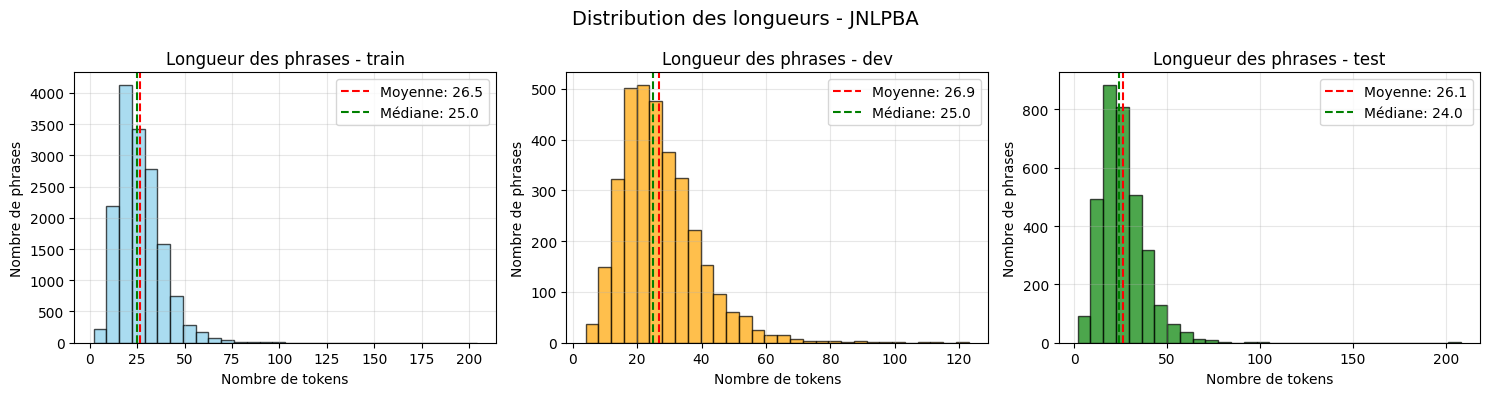


3. DISTRIBUTION DES CLASSES D'ENTITÉS
----------------------------------------

Fréquences absolues:
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                       322,900     70,740     70,970
B-DNA                     7,713      2,019        857
B-RNA                       732        241         96
B-cell_line               3,196        741        393
B-cell_type               5,853      1,056      1,730
B-protein                26,352      4,477      4,507
I-DNA                    12,762      3,404      1,397
I-RNA                     1,106        455        156
I-cell_line               6,234      1,350        792
I-cell_type               7,733      1,315      2,691
I-protein                20,849      4,551      4,222

Pourcentages (par split):
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                         77.7%      78.3%      80.8%
B-DNA  

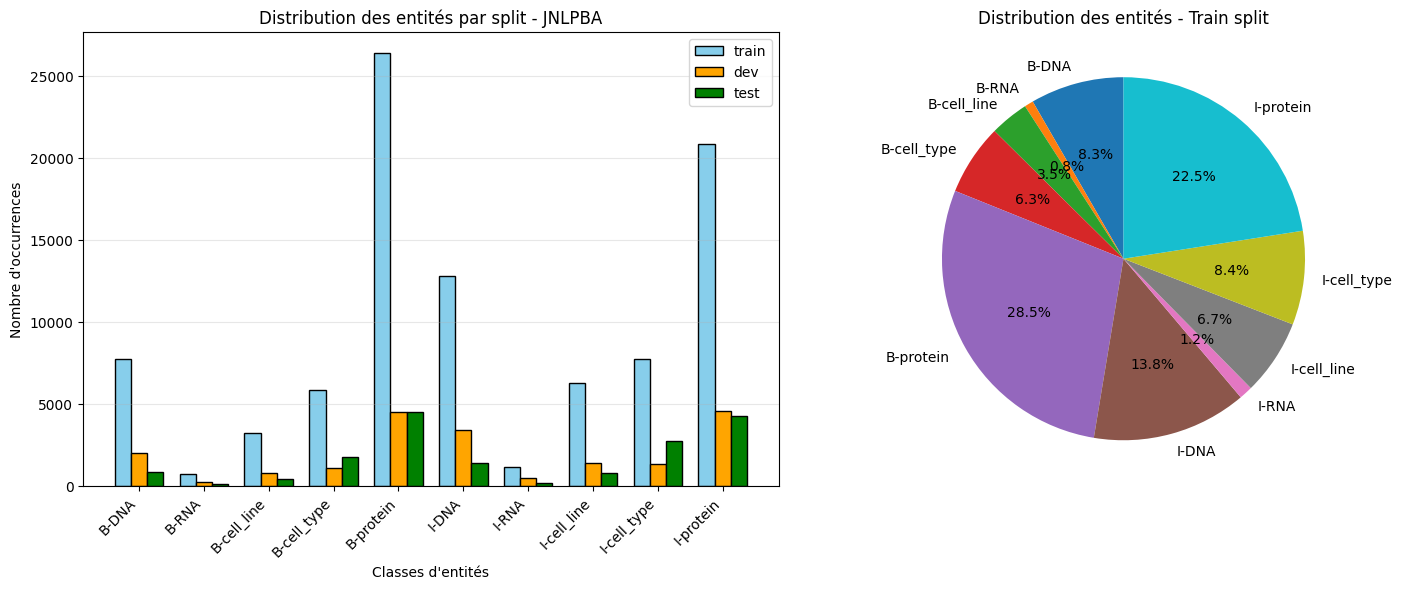


5. ENTITÉS PAR PHRASE
----------------------------------------

TRAIN:
  Entités/phrase (moyenne): 5.90
  Entités/phrase (médiane): 5.0
  Phrases sans entité: 1,553 (9.9%)

DEV:
  Entités/phrase (moyenne): 5.84
  Entités/phrase (médiane): 5.0
  Phrases sans entité: 412 (12.3%)

TEST:
  Entités/phrase (moyenne): 5.01
  Entités/phrase (médiane): 4.0
  Phrases sans entité: 571 (17.0%)


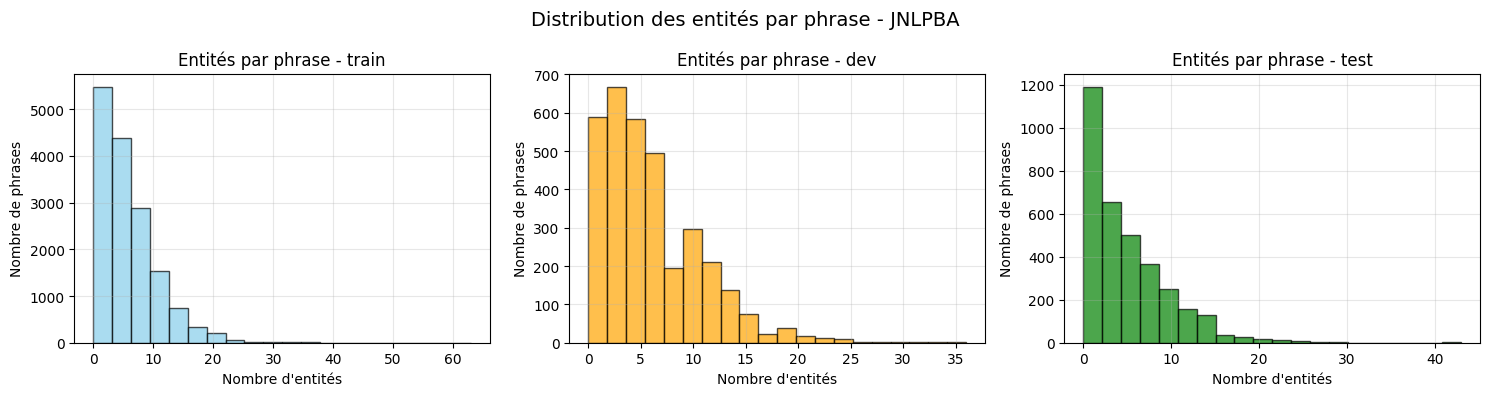


6. ANALYSE DES TAGS BIO
----------------------------------------
Total des tags: 593,590
  B: 59,963 (10.1%)
  I: 69,017 (11.6%)
  O: 464,610 (78.3%)
  autres: 0 (0.0%)

7. INFORMATIONS SUPPLÉMENTAIRES
----------------------------------------
Taille du vocabulaire: 12,664 mots
Taille du vocabulaire caractères: 85
Nombre de classes uniques: 12
Classes: ['<PAD>', 'B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']

ANALYSE TERMINÉE


In [7]:
visualize_dataset_distribution(results_jnlpba, dataset_name="JNLPBA")

Model architecture

In [ ]:
from tqdm import tqdm
def train_epoch(model, dataloader, optimizer, device):
    """
    Entraînement pour une epoch avec CRF
    """
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader,total=len(dataloader),desc="Training"):
        word_ids, char_seqs, tag_ids, lengths = batch

        word_ids = word_ids.to(device)
        char_seqs = char_seqs.to(device)
        tag_ids = tag_ids.to(device)

        mask = (word_ids != 0)
        optimizer.zero_grad()
        # Passer les tags -> forward retourne la loss directement
        loss = model(word_ids, char_seqs, mask, tag_ids)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device, idx_to_tag):
    """
    Evaluate model (CRF)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            word_ids, char_seqs, tag_ids, lengths = batch

            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)

            mask = (word_ids != 0)

            # Calculer la loss (tags fournis)
            loss = model(word_ids, char_seqs, mask, tag_ids)
            total_loss += loss.item()

            # Décoder les séquences pour obtenir les prédictions
            predictions = model(word_ids, char_seqs, mask, tags=None)  # renvoie une list
            # Stocker les prédictions et targets
            for preds_seq, tag_seq, seq_len in zip(predictions, tag_ids, lengths):
                preds_seq = preds_seq[:seq_len]          # découper au vrai length
                tag_seq = tag_seq[:seq_len].cpu().numpy()  # tag_ids tensor -> numpy

                pred_tags = [idx_to_tag.get(idx, 'O') for idx in preds_seq]
                target_tags = [idx_to_tag.get(idx, 'O') for idx in tag_seq]

                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)

    return total_loss / len(dataloader), all_predictions, all_targets



def calculate_metrics(predictions, targets):
    """
    Calculate precision, recall, F1-score
    """
    
    
    # Filter out 'O' tags for entity-specific metrics
    entity_preds = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O' or pred != 'O':
            entity_preds.append(pred)
            entity_targets.append(target)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='macro', zero_division=0
    )
    
    return precision, recall, f1


JNLPBA Dataset

In [7]:
def run_pipeline(
    dataset_name: str,
    loaders: dict,
    use_char_cnn: bool = False,
    use_char_lstm: bool = False,
    use_attention: bool = False,
    use_fc_fusion: bool = False,
    embedding_url: str = None,
    lstm_hidden_dim: Optional[int] = None,
    epochs: int = 40,
    patience: int = 4,   
    checkpoints_dir="./checkpoints",
):
    train_loader = loaders['train_loader']
    dev_loader   = loaders['dev_loader']
    test_loader  = loaders['test_loader']

    vocab        = loaders['vocab']
    char_vocab   = loaders['char_vocab']
    tag_to_idx   = loaders['tag_to_idx']
    idx_to_tag   = loaders['idx_to_tag']

    comb_name = "WE"
    if use_char_cnn and use_char_lstm:
        comb_name += "_char_bilstm_cnn"
    elif use_char_cnn:
        comb_name += "_char_cnn"
    elif use_char_lstm:
        comb_name += "_char_bilstm"

    if use_attention:
        comb_name += "_attention"
    if use_fc_fusion:
        comb_name += "_fc"

    checkpoints_path = f"{checkpoints_dir}/{comb_name}/best_model.pt"
    os.makedirs(os.path.dirname(checkpoints_path), exist_ok=True)

    # Chargement des embeddings
    if embedding_url:
        pretrained_embeddings = load_word2vec_model(embedding_url)
    elif 'pretrained_embeddings' in loaders and loaders['pretrained_embeddings'] is not None:
        pretrained_embeddings = loaders['pretrained_embeddings']
    else:
        print("Embedding nul")
        return

    if lstm_hidden_dim is None:
        lstm_hidden_dim = 256 if dataset_name == 'JNLPBA' else 128

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = CombinatorialNER(
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        dataset=dataset_name,
        use_char_cnn=use_char_cnn,
        use_char_lstm=use_char_lstm,
        use_attention=use_attention,
        use_fc_fusion=use_fc_fusion,
        pretrained_embeddings=pretrained_embeddings,
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=0.5
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Adam optimizer avec L2 / weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    # Scheduler manuel: decay rate selon dataset
    decay_rate = 0.90 if dataset_name == 'JNLPBA' else 0.95

    best_f1 = 0.0
    patience_counter = 0
    history = {
        'train_loss': [], 'dev_loss': [], 'dev_f1': [],
        'dev_precision': [], 'dev_recall': [], 'lr': []
    }

    for epoch in range(epochs):
        # 1. Train
        train_loss = train_epoch(model, train_loader, optimizer, device)

        # 2. Eval
        dev_loss, dev_preds, dev_targets = evaluate(model, dev_loader, device, idx_to_tag)
        precision, recall, f1 = calculate_metrics(dev_preds, dev_targets)

        # 3. Appliquer decay rate
        for g in optimizer.param_groups:
            g['lr'] *= decay_rate

        # 4. Historique
        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)
        history['dev_f1'].append(f1)
        history['dev_precision'].append(precision)
        history['dev_recall'].append(recall)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(
            f"Epoch {epoch+1:02d}/{epochs} | "
            f"Train loss: {train_loss:.4f} | "
            f"Dev loss: {dev_loss:.4f} | "
            f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # 5. Early stopping
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, checkpoints_path)
            print(f"Meilleur modèle sauvegardé: F1 {f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered après {epoch+1} epochs.")
            break

    # Charger meilleur modèle
    checkpoint = torch.load(checkpoints_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_preds, test_targets = evaluate(model, test_loader, device, idx_to_tag)
    precision, recall, f1 = calculate_metrics(test_preds, test_targets)

    print("\n" + "="*50)
    print("RÉSULTATS FINAUX SUR LE TEST SET")
    print("="*50)
    print(f"Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("="*50)

    return model, history


## Combinaison 1:  WE

In [10]:
model_jnlpba_we, history_jnlpba_we = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 2,535,380


Training: 100%|██████████| 491/491 [02:02<00:00,  4.00it/s]


Epoch 01/40 | Train loss: 543.3587 | Dev loss: 344.3488 | P: 0.5390 R: 0.3410 F1: 0.3980 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.3980


Training: 100%|██████████| 491/491 [01:42<00:00,  4.81it/s]


Epoch 02/40 | Train loss: 257.7546 | Dev loss: 269.9686 | P: 0.6272 R: 0.4102 F1: 0.4652 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.4652


Training: 100%|██████████| 491/491 [02:09<00:00,  3.79it/s]


Epoch 03/40 | Train loss: 198.4522 | Dev loss: 229.3467 | P: 0.6755 R: 0.4505 F1: 0.5135 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.5135


Training: 100%|██████████| 491/491 [02:09<00:00,  3.80it/s]


Epoch 04/40 | Train loss: 165.4975 | Dev loss: 206.0610 | P: 0.6809 R: 0.4741 F1: 0.5350 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.5350


Training: 100%|██████████| 491/491 [01:50<00:00,  4.43it/s]


Epoch 05/40 | Train loss: 144.7595 | Dev loss: 189.6846 | P: 0.6767 R: 0.4935 F1: 0.5554 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.5554


Training: 100%|██████████| 491/491 [01:44<00:00,  4.72it/s]


Epoch 06/40 | Train loss: 130.7567 | Dev loss: 178.0972 | P: 0.6945 R: 0.5145 F1: 0.5740 | LR: 0.000531
Meilleur modèle sauvegardé: F1 0.5740


Training: 100%|██████████| 491/491 [01:46<00:00,  4.60it/s]


Epoch 07/40 | Train loss: 120.7740 | Dev loss: 169.5909 | P: 0.6921 R: 0.5208 F1: 0.5776 | LR: 0.000478
Meilleur modèle sauvegardé: F1 0.5776


Training: 100%|██████████| 491/491 [01:53<00:00,  4.31it/s]


Epoch 08/40 | Train loss: 113.3705 | Dev loss: 163.8052 | P: 0.6986 R: 0.5194 F1: 0.5798 | LR: 0.000430
Meilleur modèle sauvegardé: F1 0.5798


Training: 100%|██████████| 491/491 [01:42<00:00,  4.81it/s]


Epoch 09/40 | Train loss: 107.7013 | Dev loss: 158.7527 | P: 0.6979 R: 0.5259 F1: 0.5838 | LR: 0.000387
Meilleur modèle sauvegardé: F1 0.5838


Training: 100%|██████████| 491/491 [01:42<00:00,  4.78it/s]


Epoch 10/40 | Train loss: 103.2629 | Dev loss: 155.3703 | P: 0.6968 R: 0.5297 F1: 0.5861 | LR: 0.000349
Meilleur modèle sauvegardé: F1 0.5861


Training: 100%|██████████| 491/491 [05:32<00:00,  1.48it/s]


Epoch 11/40 | Train loss: 99.7435 | Dev loss: 152.0434 | P: 0.7023 R: 0.5371 F1: 0.5941 | LR: 0.000314
Meilleur modèle sauvegardé: F1 0.5941


Training: 100%|██████████| 491/491 [05:40<00:00,  1.44it/s]


Epoch 12/40 | Train loss: 96.9401 | Dev loss: 150.1045 | P: 0.6951 R: 0.5385 F1: 0.5912 | LR: 0.000282


Training: 100%|██████████| 491/491 [05:24<00:00,  1.51it/s]


Epoch 13/40 | Train loss: 94.5801 | Dev loss: 148.1056 | P: 0.6991 R: 0.5398 F1: 0.5947 | LR: 0.000254
Meilleur modèle sauvegardé: F1 0.5947


Training: 100%|██████████| 491/491 [05:22<00:00,  1.52it/s]


Epoch 14/40 | Train loss: 92.6359 | Dev loss: 146.6203 | P: 0.6974 R: 0.5404 F1: 0.5945 | LR: 0.000229


Training: 100%|██████████| 491/491 [05:35<00:00,  1.46it/s]


Epoch 15/40 | Train loss: 91.0259 | Dev loss: 145.2073 | P: 0.6994 R: 0.5429 F1: 0.5964 | LR: 0.000206
Meilleur modèle sauvegardé: F1 0.5964


Training: 100%|██████████| 491/491 [01:49<00:00,  4.48it/s]


Epoch 16/40 | Train loss: 89.6621 | Dev loss: 143.9105 | P: 0.6969 R: 0.5454 F1: 0.5967 | LR: 0.000185
Meilleur modèle sauvegardé: F1 0.5967


Training: 100%|██████████| 491/491 [01:44<00:00,  4.69it/s]


Epoch 17/40 | Train loss: 88.4651 | Dev loss: 143.1685 | P: 0.6946 R: 0.5403 F1: 0.5937 | LR: 0.000167


Training: 100%|██████████| 491/491 [03:49<00:00,  2.14it/s]


Epoch 18/40 | Train loss: 87.4562 | Dev loss: 142.5513 | P: 0.6985 R: 0.5433 F1: 0.5972 | LR: 0.000150
Meilleur modèle sauvegardé: F1 0.5972


Training: 100%|██████████| 491/491 [05:08<00:00,  1.59it/s]


Epoch 19/40 | Train loss: 86.6067 | Dev loss: 141.8110 | P: 0.6931 R: 0.5465 F1: 0.5975 | LR: 0.000135
Meilleur modèle sauvegardé: F1 0.5975


Training: 100%|██████████| 491/491 [02:19<00:00,  3.51it/s]


Epoch 20/40 | Train loss: 85.8661 | Dev loss: 141.2796 | P: 0.6954 R: 0.5480 F1: 0.5993 | LR: 0.000122
Meilleur modèle sauvegardé: F1 0.5993


Training: 100%|██████████| 491/491 [02:10<00:00,  3.77it/s]


Epoch 21/40 | Train loss: 85.2204 | Dev loss: 140.8451 | P: 0.6991 R: 0.5511 F1: 0.6024 | LR: 0.000109
Meilleur modèle sauvegardé: F1 0.6024


Training: 100%|██████████| 491/491 [02:01<00:00,  4.05it/s]


Epoch 22/40 | Train loss: 84.6544 | Dev loss: 140.5849 | P: 0.7014 R: 0.5491 F1: 0.6026 | LR: 0.000098
Meilleur modèle sauvegardé: F1 0.6026


Training: 100%|██████████| 491/491 [02:16<00:00,  3.59it/s]


Epoch 23/40 | Train loss: 84.1625 | Dev loss: 139.9844 | P: 0.6990 R: 0.5536 F1: 0.6050 | LR: 0.000089
Meilleur modèle sauvegardé: F1 0.6050


Training: 100%|██████████| 491/491 [01:51<00:00,  4.40it/s]


Epoch 24/40 | Train loss: 83.7195 | Dev loss: 139.8574 | P: 0.6996 R: 0.5505 F1: 0.6029 | LR: 0.000080


Training: 100%|██████████| 491/491 [01:45<00:00,  4.64it/s]


Epoch 25/40 | Train loss: 83.3375 | Dev loss: 139.6509 | P: 0.7005 R: 0.5504 F1: 0.6032 | LR: 0.000072


Training: 100%|██████████| 491/491 [01:53<00:00,  4.32it/s]


Epoch 26/40 | Train loss: 83.0117 | Dev loss: 139.2846 | P: 0.7001 R: 0.5622 F1: 0.6131 | LR: 0.000065
Meilleur modèle sauvegardé: F1 0.6131


Training: 100%|██████████| 491/491 [01:50<00:00,  4.44it/s]


Epoch 27/40 | Train loss: 82.7101 | Dev loss: 139.0452 | P: 0.6996 R: 0.5629 F1: 0.6135 | LR: 0.000058
Meilleur modèle sauvegardé: F1 0.6135


Training: 100%|██████████| 491/491 [02:05<00:00,  3.92it/s]


Epoch 28/40 | Train loss: 82.4483 | Dev loss: 139.0201 | P: 0.7016 R: 0.5606 F1: 0.6127 | LR: 0.000052


Training: 100%|██████████| 491/491 [01:47<00:00,  4.56it/s]


Epoch 29/40 | Train loss: 82.2194 | Dev loss: 138.8736 | P: 0.6994 R: 0.5617 F1: 0.6127 | LR: 0.000047


Training: 100%|██████████| 491/491 [01:54<00:00,  4.29it/s]


Epoch 30/40 | Train loss: 82.0093 | Dev loss: 138.5997 | P: 0.6994 R: 0.5646 F1: 0.6145 | LR: 0.000042
Meilleur modèle sauvegardé: F1 0.6145


Training: 100%|██████████| 491/491 [01:41<00:00,  4.82it/s]


Epoch 31/40 | Train loss: 81.8235 | Dev loss: 138.4795 | P: 0.7002 R: 0.5655 F1: 0.6156 | LR: 0.000038
Meilleur modèle sauvegardé: F1 0.6156


Training: 100%|██████████| 491/491 [01:41<00:00,  4.85it/s]


Epoch 32/40 | Train loss: 81.6622 | Dev loss: 138.4841 | P: 0.7019 R: 0.5618 F1: 0.6141 | LR: 0.000034


Training: 100%|██████████| 491/491 [01:55<00:00,  4.25it/s]


Epoch 33/40 | Train loss: 81.5177 | Dev loss: 138.3391 | P: 0.7002 R: 0.5656 F1: 0.6157 | LR: 0.000031
Meilleur modèle sauvegardé: F1 0.6157


Training: 100%|██████████| 491/491 [01:43<00:00,  4.76it/s]


Epoch 34/40 | Train loss: 81.3872 | Dev loss: 138.3632 | P: 0.7016 R: 0.5623 F1: 0.6143 | LR: 0.000028


Training: 100%|██████████| 491/491 [05:20<00:00,  1.53it/s]


Epoch 35/40 | Train loss: 81.2696 | Dev loss: 138.1957 | P: 0.7007 R: 0.5649 F1: 0.6156 | LR: 0.000025


Training: 100%|██████████| 491/491 [05:01<00:00,  1.63it/s]


Epoch 36/40 | Train loss: 81.1658 | Dev loss: 138.1090 | P: 0.6997 R: 0.5650 F1: 0.6153 | LR: 0.000023


Training: 100%|██████████| 491/491 [04:18<00:00,  1.90it/s]


Epoch 37/40 | Train loss: 81.0709 | Dev loss: 138.1034 | P: 0.7003 R: 0.5648 F1: 0.6156 | LR: 0.000020
Early stopping triggered après 37 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 147.3022
Precision: 0.6266
Recall: 0.5383
F1-score: 0.5768


In [8]:
def print_model_layers(model: torch.nn.Module):
    print(f"{'Layer (type)':30} | {'Param #':>12}")
    print("-"*45)
    total_params = 0
    for name, module in model.named_modules():
        if len(list(module.children())) == 0: 
            param_count = sum(p.numel() for p in module.parameters())
            print(f"{name + ' (' + module.__class__.__name__ + ')':30} | {param_count:12,}")
            total_params += param_count
    print("-"*45)
    print(f"{'Total parameters':30} | {total_params:12,}")


In [12]:
print_model_layers(model_jnlpba_we)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
emission (Linear)              |        2,412
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    2,535,380


In [13]:
import pickle
import os

def save_vocabularies(data_dict, save_dir):
    """Sauvegarde les vocabulaires et mappings"""
    os.makedirs(save_dir, exist_ok=True)
    
    with open(os.path.join(save_dir, 'vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['vocab'], f)
    
    with open(os.path.join(save_dir, 'char_vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['char_vocab'], f)
    
    with open(os.path.join(save_dir, 'tag_to_idx.pkl'), 'wb') as f:
        pickle.dump(data_dict['tag_to_idx'], f)
    
    with open(os.path.join(save_dir, 'idx_to_tag.pkl'), 'wb') as f:
        pickle.dump(data_dict['idx_to_tag'], f)
    
    print(f"Vocabulaires sauvegardés dans {save_dir}")
    
save_vocabularies(results_jnlpba, './vocab/jnlpba')

Vocabulaires sauvegardés dans ./vocab/jnlpba


In [40]:
import matplotlib.pyplot as plt

def plot_training_history(history, dataset_name):
    """
    Visualise l'historique d'entraînement avec Loss, F1, Precision, Recall
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 11))
    fig.suptitle(f'Training History - {dataset_name}', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    # ─────────────────────────────────────────────
    # Plot 1: Train vs Dev Loss
    # ─────────────────────────────────────────────
    axes[0, 0].plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Train vs Dev Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 2: Dev Precision / Recall / F1
    # ─────────────────────────────────────────────
    axes[0, 1].plot(epochs, history['dev_precision'], label='Precision', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_recall'], label='Recall', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_f1'], label='F1-score', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_title('Dev Precision / Recall / F1')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 3: Learning Rate
    # ─────────────────────────────────────────────
    axes[1, 0].step(epochs, history['lr'], linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 4: Dev Loss vs F1 (double axis)
    # ─────────────────────────────────────────────
    ax_loss = axes[1, 1]
    ax_f1 = ax_loss.twinx()

    line1, = ax_loss.plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2,color="red")
    line2, = ax_f1.plot(epochs, history['dev_f1'], label='Dev F1', linewidth=2,color="green")

    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_f1.set_ylabel('F1-score')
    ax_loss.set_title('Dev Loss & F1-score')

    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax_loss.legend(lines, labels, loc='upper right')

    ax_loss.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ─────────────────────────────────────────────
    # Résumé numérique final
    # ─────────────────────────────────────────────
    print(f"\nSTATISTIQUES FINALES - {dataset_name}")
    print(f"Meilleur F1 (dev)       : {max(history['dev_f1']):.4f}")
    print(f"Meilleure Precision(dev): {max(history['dev_precision']):.4f}")
    print(f"Meilleur Recall (dev)   : {max(history['dev_recall']):.4f}")
    print(f"Final train loss        : {history['train_loss'][-1]:.4f}")
    print(f"Final dev loss          : {history['dev_loss'][-1]:.4f}")
    print(f"Final learning rate     : {history['lr'][-1]:.6f}")


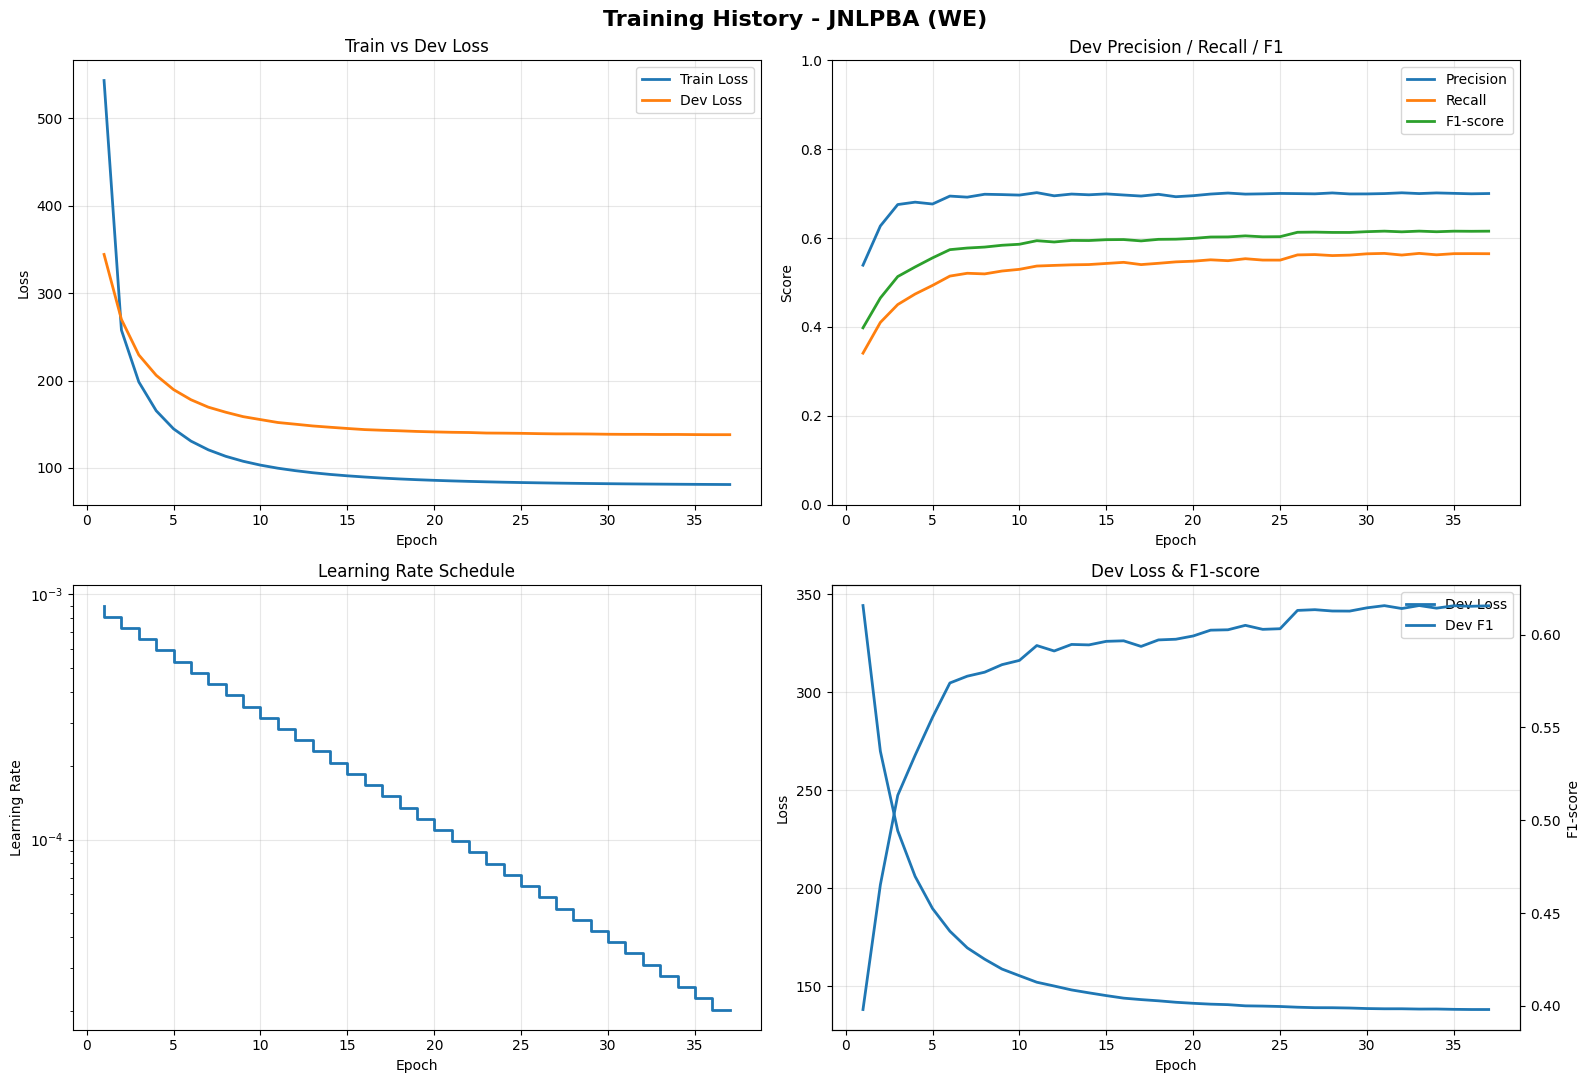


STATISTIQUES FINALES - JNLPBA (WE)
Meilleur F1 (dev)       : 0.6157
Meilleure Precision(dev): 0.7023
Meilleur Recall (dev)   : 0.5656
Final train loss        : 81.0709
Final dev loss          : 138.1034
Final learning rate     : 0.000020


In [15]:
plot_training_history(history_jnlpba_we, dataset_name="JNLPBA (WE)")

In [10]:
def load_trained_model(model_path, dataset_name, loaders_dict,use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False):
    """
    Charge un modèle entraîné et le prépare pour les prédictions
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Récupérer les paramètres du loader
    vocab = loaders_dict['vocab']
    char_vocab = loaders_dict['char_vocab']
    tag_to_idx = loaders_dict['tag_to_idx']
    idx_to_tag = loaders_dict['idx_to_tag']
    
    # Déterminer les paramètres selon le dataset
    if dataset_name == 'JNLPBA':
        lstm_hidden = 256
    else:  # NCBI-Disease
        lstm_hidden = 128
    
    # Créer le modèle
    model = CombinatorialNER(
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=use_char_cnn,       
    use_char_lstm=use_char_lstm,      
    use_attention=use_attention,     
    use_fc_fusion=use_fc_fusion,  
    pretrained_embeddings=None,  
    word_embed_dim=200,
    lstm_hidden_dim=lstm_hidden,
    dropout=0.5
).to(device)

    
    # Charger les poids sauvegardés
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Mode évaluation
    
    print(f"Modèle chargé depuis: {model_path}")
    print(f"Best F1 enregistré: {checkpoint.get('best_f1', 'N/A'):.4f}")
    print(f"Époque: {checkpoint.get('epoch', 'N/A')}")
    
    return model, device, idx_to_tag

def plot_confusion_matrix_by_class(predictions, targets, idx_to_tag, dataset_name, 
                                   normalize=True, figsize=(12, 10),title="Matrice de confusion"):
    """
    Affiche la matrice de confusion par classe avec des statistiques détaillées
    """
    # Vérification des types
    print(f"\nVérification des types:")
    print(f"  Type predictions[0]: {type(predictions[0])}, valeur: {predictions[0]}")
    print(f"  Type targets[0]: {type(targets[0])}, valeur: {targets[0]}")
    
    # S'assurer que tout est string
    predictions = [str(p) for p in predictions]
    targets = [str(t) for t in targets]
    
    # Filtrer les tags 'O' pour se concentrer sur les entités
    entity_predictions = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O':  
            entity_predictions.append(pred)
            entity_targets.append(target)
    
    print(f"\nStatistiques:")
    print(f"  Total tokens: {len(predictions)}")
    print(f"  Entity tokens: {len(entity_targets)}")
    print(f"  Unique entity tags in targets: {set(entity_targets)}")
    print(f"  Unique entity tags in predictions: {set(entity_predictions)}")
    
    # Obtenir les classes uniques (sauf 'O')
    all_unique_tags = sorted(set(entity_targets + entity_predictions))
    
    # Filtrer pour garder seulement les tags valides (pas les nombres)
    valid_tags = [tag for tag in all_unique_tags if not tag.isdigit()]
    
    # Si on a des tags numériques, c'est qu'il y a un problème de conversion
    numeric_tags = [tag for tag in all_unique_tags if tag.isdigit()]
    if numeric_tags:
        print(f"\nATTENTION: Tags numériques trouvés: {numeric_tags}")
        print("Cela indique que les prédictions sont des indices, pas des tags!")
        print(f"Mapping idx_to_tag: {dict(list(idx_to_tag.items())[:10])}")
    
    print(f"  Tags valides à plotter: {valid_tags}")
    
    if not valid_tags:
        print("Aucune entité valide trouvée dans les données!")
        return

    cm = confusion_matrix(entity_targets, entity_predictions, labels=valid_tags)
    supports = cm.sum(axis=1)  
    
    if normalize:
        # Éviter la division par zéro
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_normalized = cm.astype('float') / supports[:, np.newaxis]
            cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)
        cm_to_plot = cm_normalized
        fmt = '.2f'
    else:
        cm_to_plot = cm
        fmt = 'd'
    
    # Créer la figure
    plt.figure(figsize=figsize)
    
    # Si la matrice est trop grande, ajuster la taille
    if len(valid_tags) > 15:
        figsize = (max(12, len(valid_tags)), max(10, len(valid_tags)))
        plt.figure(figsize=figsize)
    
    sns.heatmap(cm_to_plot, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=valid_tags, yticklabels=valid_tags,
                cbar_kws={'label': 'Proportion' if normalize else 'Count'})
    
    plt.title(title,fontsize=14, fontweight='bold')
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    filtered_targets = []
    filtered_preds = []
    
    for t, p in zip(entity_targets, entity_predictions):
        if t in valid_tags and p in valid_tags:
            filtered_targets.append(t)
            filtered_preds.append(p)
    
    if filtered_targets:
        report = classification_report(filtered_targets, filtered_preds, 
                                       labels=valid_tags, zero_division=0)
        print(report)
    else:
        print("Pas assez de données pour générer le rapport")

def predict_on_test_set(model, test_loader, device, idx_to_tag):
    """
    Version simplifiée et robuste
    """
    shown_example = False
    model.eval()
    all_predictions = []
    all_targets = []
    for idx, tag in sorted(idx_to_tag.items()):
        print(f"  {idx} -> {tag}")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            word_ids, char_seqs, tag_ids, lengths = batch
            
            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)
            mask = (word_ids != 0)
            pred_sequences = model(word_ids, char_seqs, mask, tags=None)
            
            for i in range(len(word_ids)):
                actual_len = lengths[i]
                if isinstance(pred_sequences, list):
                    pred_seq = pred_sequences[i][:actual_len]
                else:
                    pred_seq = torch.argmax(pred_sequences[i], dim=1)[:actual_len].cpu().numpy()
                
                # Convertir indices -> tags
                pred_tags = []
                for idx in pred_seq:
                    if isinstance(idx, torch.Tensor):
                        idx = idx.item()
                    tag = idx_to_tag.get(int(idx), 'O')
                    pred_tags.append(tag)
                
                # Convertir cibles indices -> tags
                target_indices = tag_ids[i][:actual_len].cpu().numpy()
                target_tags = [idx_to_tag.get(int(idx), 'O') for idx in target_indices]
                
                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)
                if not shown_example:
                    for pos, (g, p) in enumerate(zip(target_tags, pred_tags)):
                            mark = "correct" if g == p else "incorrect"
                            print(f"{pos:3d} | {g:18s} | {p:18s} {mark}")
                    shown_example=True
    
    return all_predictions, all_targets  


In [17]:
model_path = "./checkpoints/JNLPBA/we/best_model.pt"
model, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_jnlpba['test_loader']
predictions, targets = predict_on_test_set(
    model=model,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/we/best_model.pt
Best F1 enregistré: 0.6157
Époque: 32
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O                  correct



Accuracy globale: 0.9082

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 16841
  Unique entity tags in targets: {'B-DNA', 'B-protein', 'I-cell_line', 'I-DNA', 'B-cell_line', 'I-RNA', 'I-protein', 'B-RNA', 'I-cell_type', 'B-cell_type'}
  Unique entity tags in predictions: {'B-DNA', 'B-protein', 'I-DNA', 'I-cell_line', 'B-cell_line', 'I-RNA', 'I-protein', 'O', 'B-RNA', 'I-cell_type', 'B-cell_type'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


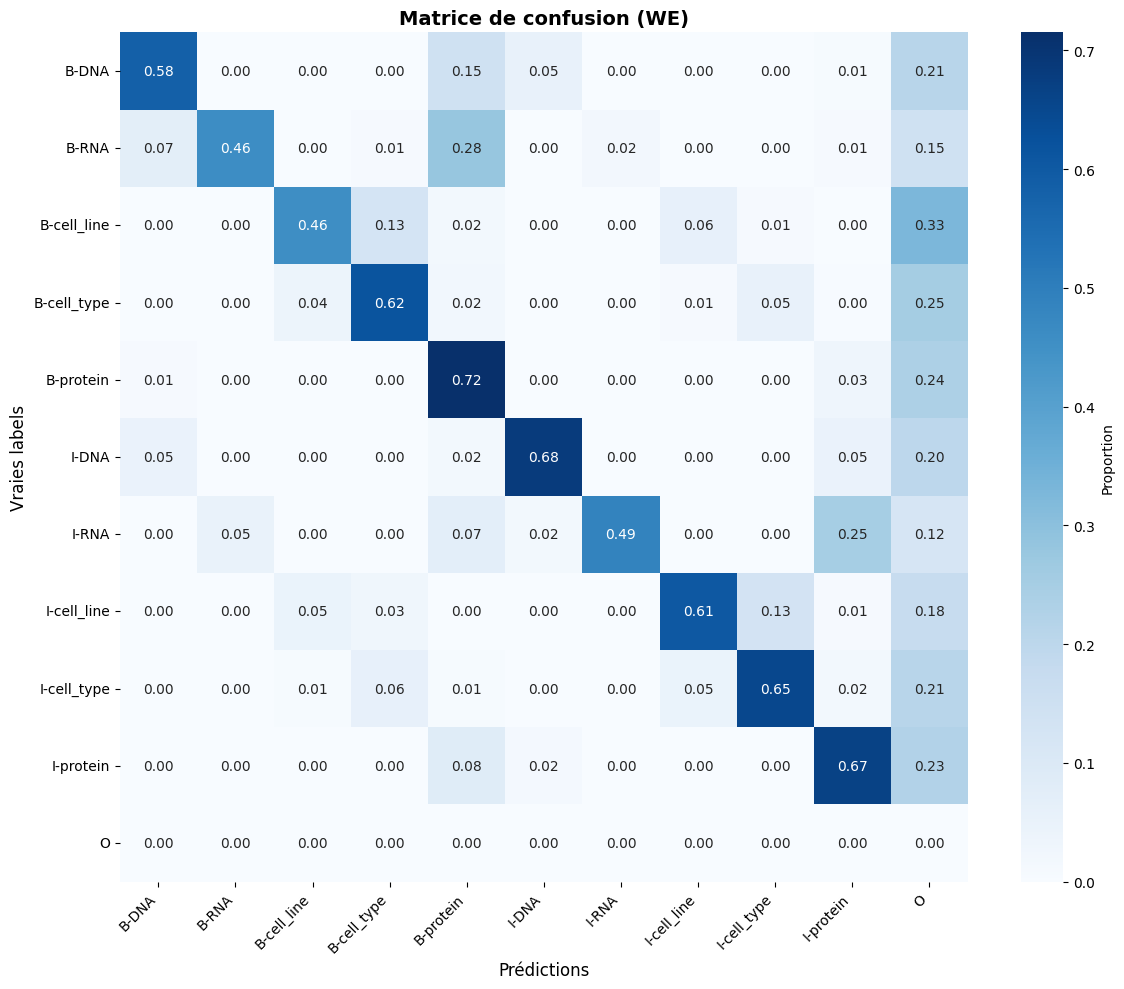

              precision    recall  f1-score   support

       B-DNA       0.80      0.58      0.67       857
       B-RNA       0.75      0.46      0.57        96
 B-cell_line       0.58      0.46      0.51       393
 B-cell_type       0.81      0.62      0.70      1730
   B-protein       0.84      0.72      0.77      4507
       I-DNA       0.88      0.68      0.77      1397
       I-RNA       0.94      0.49      0.64       156
 I-cell_line       0.74      0.61      0.66       792
 I-cell_type       0.89      0.65      0.75      2691
   I-protein       0.90      0.67      0.76      4222
           O       0.00      0.00      0.00         0

    accuracy                           0.66     16841
   macro avg       0.74      0.54      0.62     16841
weighted avg       0.85      0.66      0.74     16841



In [ ]:


# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets, predictions)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions, targets) if t != 'O']
entity_targets = [t for p, t in zip(predictions, targets) if t != 'O']

if set(predictions) == set(targets) or all(isinstance(p, str) for p in predictions):
    plot_confusion_matrix_by_class(
        predictions=predictions,
        targets=targets,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets[:10])}")

## Combinaison 2:  WE + attention

In [64]:
model_we_attention, history_we_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 2,877,300


Training:   0%|          | 0/491 [00:00<?, ?it/s]

Training: 100%|██████████| 491/491 [09:55<00:00,  1.21s/it]


Epoch 01/40 | Train loss: 340.4704 | Dev loss: 194.6842 | P: 0.7201 R: 0.6243 F1: 0.6636 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6636


Training: 100%|██████████| 491/491 [10:17<00:00,  1.26s/it]


Epoch 02/40 | Train loss: 136.4127 | Dev loss: 147.0934 | P: 0.7254 R: 0.6993 F1: 0.7104 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7104


Training: 100%|██████████| 491/491 [12:00<00:00,  1.47s/it]


Epoch 03/40 | Train loss: 103.2691 | Dev loss: 139.4610 | P: 0.7333 R: 0.6964 F1: 0.7116 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7116


Training: 100%|██████████| 491/491 [10:37<00:00,  1.30s/it]


Epoch 04/40 | Train loss: 84.5511 | Dev loss: 134.4277 | P: 0.7373 R: 0.6930 F1: 0.7125 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7125


Training: 100%|██████████| 491/491 [11:27<00:00,  1.40s/it]


Epoch 05/40 | Train loss: 72.4580 | Dev loss: 135.9010 | P: 0.7217 R: 0.7166 F1: 0.7175 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7175


Training: 100%|██████████| 491/491 [12:07<00:00,  1.48s/it]


Epoch 06/40 | Train loss: 62.0800 | Dev loss: 138.5432 | P: 0.7401 R: 0.6870 F1: 0.7110 | LR: 0.000531


Training: 100%|██████████| 491/491 [13:21<00:00,  1.63s/it]


Epoch 07/40 | Train loss: 54.0268 | Dev loss: 139.4110 | P: 0.7222 R: 0.7145 F1: 0.7169 | LR: 0.000478


Training: 100%|██████████| 491/491 [12:44<00:00,  1.56s/it]


Epoch 08/40 | Train loss: 47.0903 | Dev loss: 145.9190 | P: 0.7356 R: 0.6958 F1: 0.7140 | LR: 0.000430


Training: 100%|██████████| 491/491 [13:41<00:00,  1.67s/it]


Epoch 09/40 | Train loss: 41.1165 | Dev loss: 149.4828 | P: 0.7309 R: 0.6786 F1: 0.6993 | LR: 0.000387
Early stopping triggered après 9 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 143.7202
Precision: 0.6426
Recall: 0.6861
F1-score: 0.6610


In [65]:
print_model_layers(model_we_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
context_lstm (LSTM)            |      337,920
attention_layer.W (Linear)     |          256
emission (Linear)              |        6,156
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    2,877,300


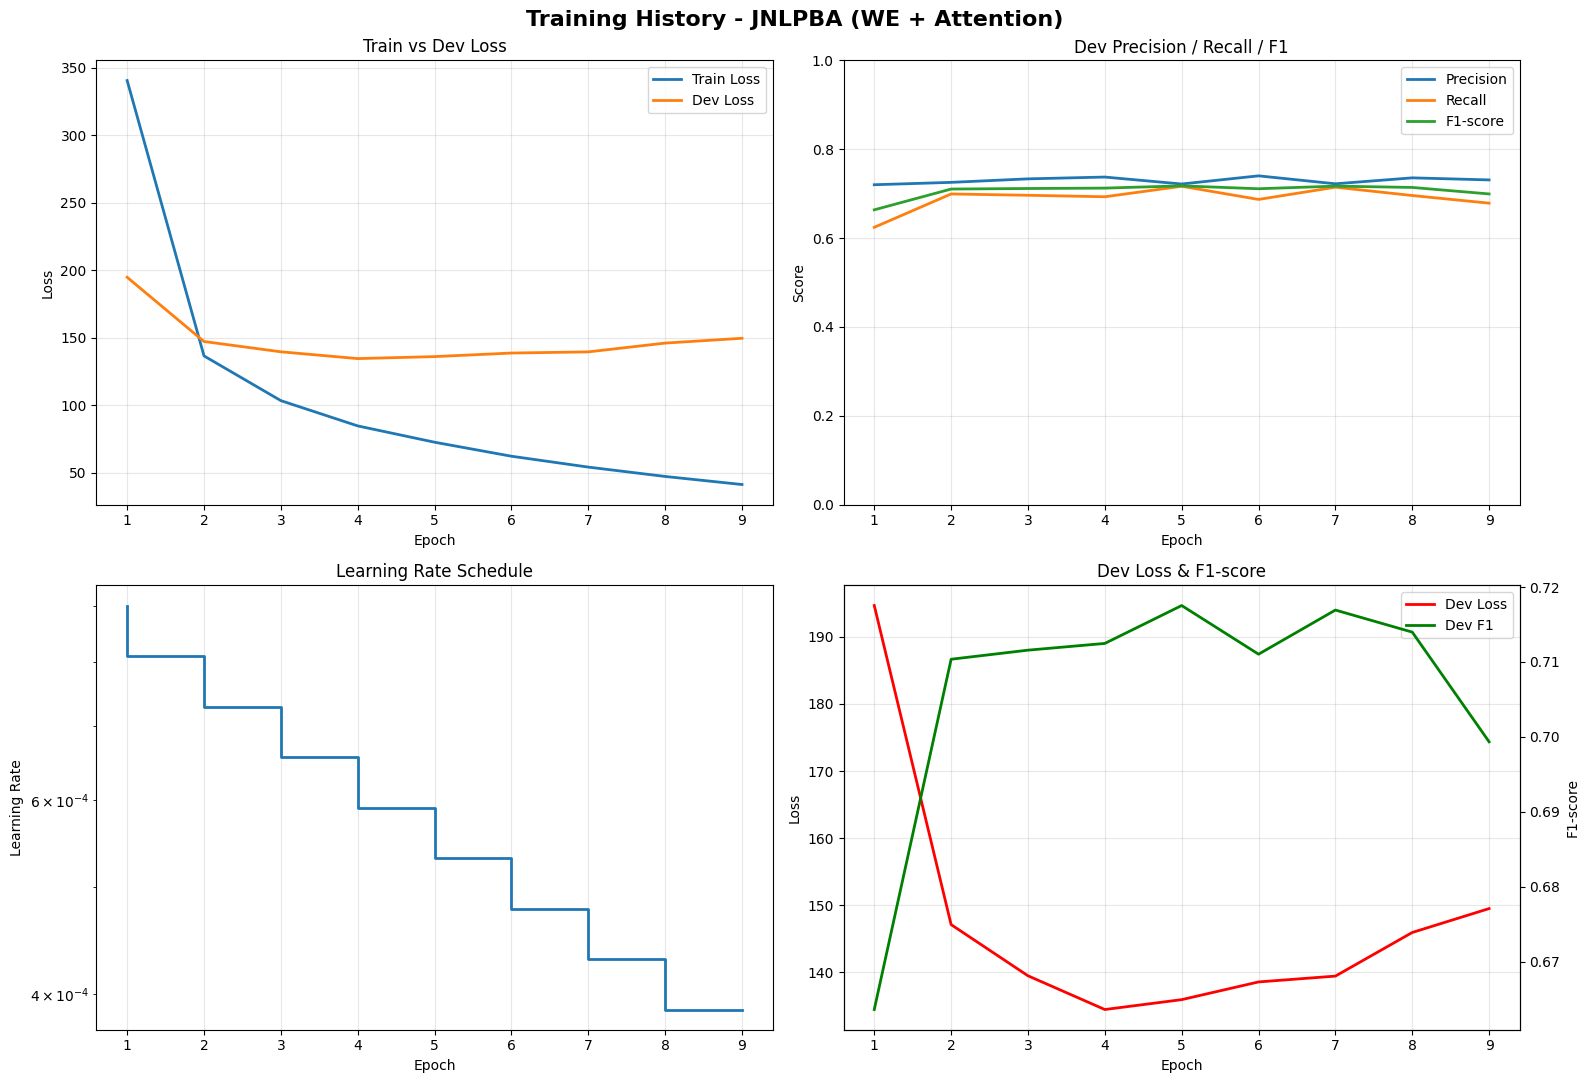


STATISTIQUES FINALES - JNLPBA (WE + Attention)
Meilleur F1 (dev)       : 0.7175
Meilleure Precision(dev): 0.7401
Meilleur Recall (dev)   : 0.7166
Final train loss        : 41.1165
Final dev loss          : 149.4828
Final learning rate     : 0.000387


In [66]:
plot_training_history(history_we_attention, dataset_name="JNLPBA (WE + Attention)")

In [23]:
model_path = "./checkpoints/JNLPBA/WE_attention/best_model.pt"
model_we_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_jnlpba['test_loader']
predictions_we_attention, targets_we_attention = predict_on_test_set(
    model=model_we_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_attention/best_model.pt
Best F1 enregistré: 0.7091
Époque: 5
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O                 


Accuracy globale: 0.9215

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 16841
  Unique entity tags in targets: {'B-cell_type', 'B-DNA', 'B-cell_line', 'I-cell_line', 'B-protein', 'I-cell_type', 'I-RNA', 'I-DNA', 'B-RNA', 'I-protein'}
  Unique entity tags in predictions: {'B-cell_type', 'B-DNA', 'B-cell_line', 'I-cell_type', 'B-protein', 'I-cell_line', 'I-RNA', 'I-DNA', 'B-RNA', 'O', 'I-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


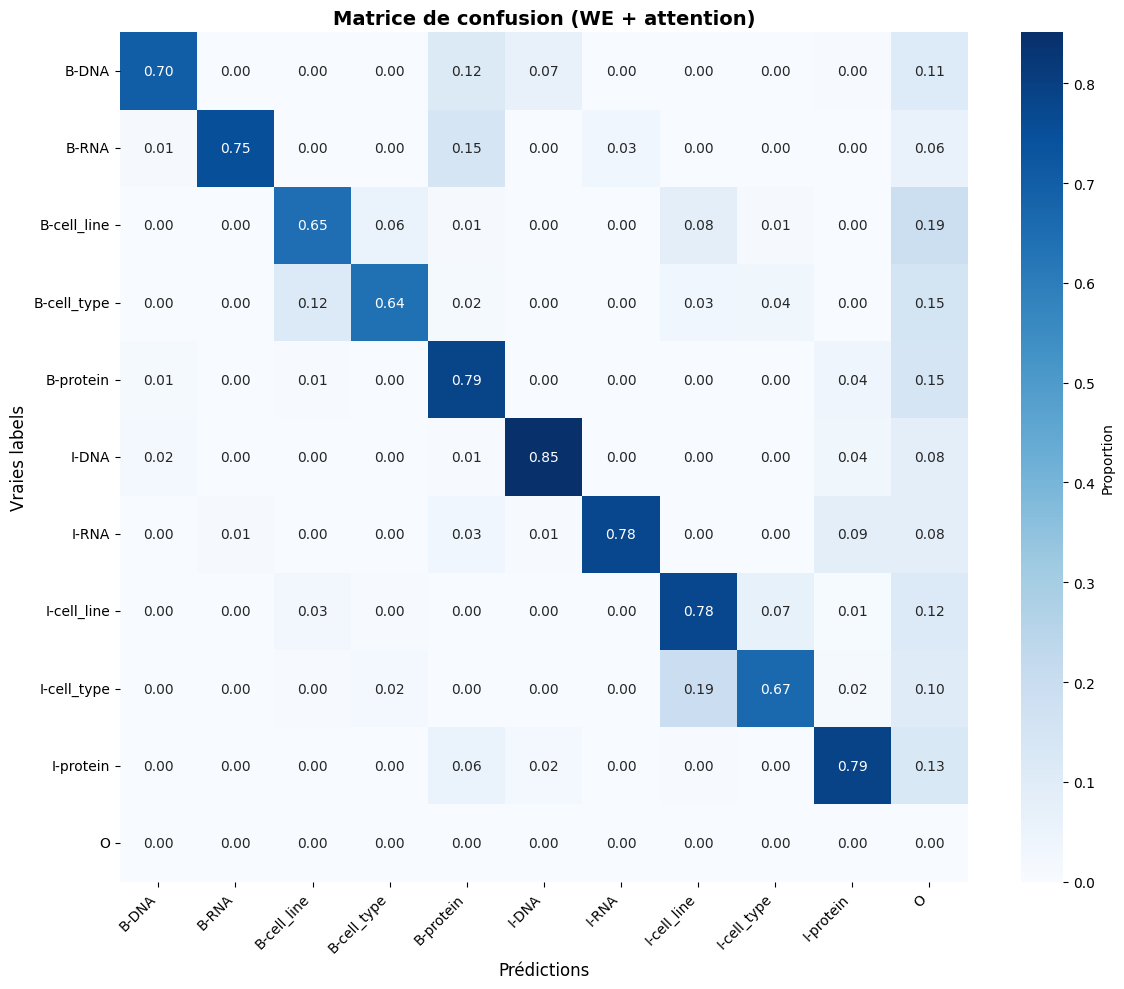

              precision    recall  f1-score   support

       B-DNA       0.85      0.70      0.77       857
       B-RNA       0.88      0.75      0.81        96
 B-cell_line       0.49      0.65      0.56       393
 B-cell_type       0.93      0.64      0.76      1730
   B-protein       0.90      0.79      0.84      4507
       I-DNA       0.89      0.85      0.87      1397
       I-RNA       0.91      0.78      0.84       156
 I-cell_line       0.50      0.78      0.61       792
 I-cell_type       0.93      0.67      0.78      2691
   I-protein       0.92      0.79      0.85      4222
           O       0.00      0.00      0.00         0

    accuracy                           0.75     16841
   macro avg       0.75      0.67      0.70     16841
weighted avg       0.88      0.75      0.81     16841



In [ ]:


# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_attention, predictions_we_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_attention, targets_we_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_attention, targets_we_attention) if t != 'O']



if set(predictions_we_attention) == set(targets_we_attention) or all(isinstance(p, str) for p in predictions_we_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_attention,
        targets=targets_we_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_attention[:10])}")

## Combinaison 3:  WE + char(bi-lstm)

In [25]:
model_we_char_bilstm , history_we_char_bilstm = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,021,422


Training: 100%|██████████| 491/491 [02:16<00:00,  3.60it/s]


Epoch 01/40 | Train loss: 310.3619 | Dev loss: 171.5013 | P: 0.7262 R: 0.6541 F1: 0.6820 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6820


Training: 100%|██████████| 491/491 [02:24<00:00,  3.39it/s]


Epoch 02/40 | Train loss: 128.0282 | Dev loss: 141.6292 | P: 0.7328 R: 0.6942 F1: 0.7111 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7111


Training: 100%|██████████| 491/491 [02:28<00:00,  3.31it/s]


Epoch 03/40 | Train loss: 97.0393 | Dev loss: 130.7335 | P: 0.7325 R: 0.7176 F1: 0.7235 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7235


Training: 100%|██████████| 491/491 [03:03<00:00,  2.68it/s]


Epoch 04/40 | Train loss: 79.9208 | Dev loss: 130.9538 | P: 0.7238 R: 0.7297 F1: 0.7253 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7253


Training: 100%|██████████| 491/491 [02:26<00:00,  3.36it/s]


Epoch 05/40 | Train loss: 67.9862 | Dev loss: 128.5169 | P: 0.7455 R: 0.7002 F1: 0.7203 | LR: 0.000590


Training: 100%|██████████| 491/491 [02:16<00:00,  3.59it/s]


Epoch 06/40 | Train loss: 58.6472 | Dev loss: 125.7718 | P: 0.7345 R: 0.7159 F1: 0.7231 | LR: 0.000531


Training: 100%|██████████| 491/491 [02:28<00:00,  3.32it/s]


Epoch 07/40 | Train loss: 51.4713 | Dev loss: 131.4372 | P: 0.7444 R: 0.6944 F1: 0.7170 | LR: 0.000478


Training: 100%|██████████| 491/491 [02:20<00:00,  3.49it/s]


Epoch 08/40 | Train loss: 45.4930 | Dev loss: 135.3824 | P: 0.7400 R: 0.7037 F1: 0.7187 | LR: 0.000430
Early stopping triggered après 8 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 148.3106
Precision: 0.6334
Recall: 0.6944
F1-score: 0.6566


In [26]:
print_model_layers(model_we_char_bilstm)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      440,320
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,021,422


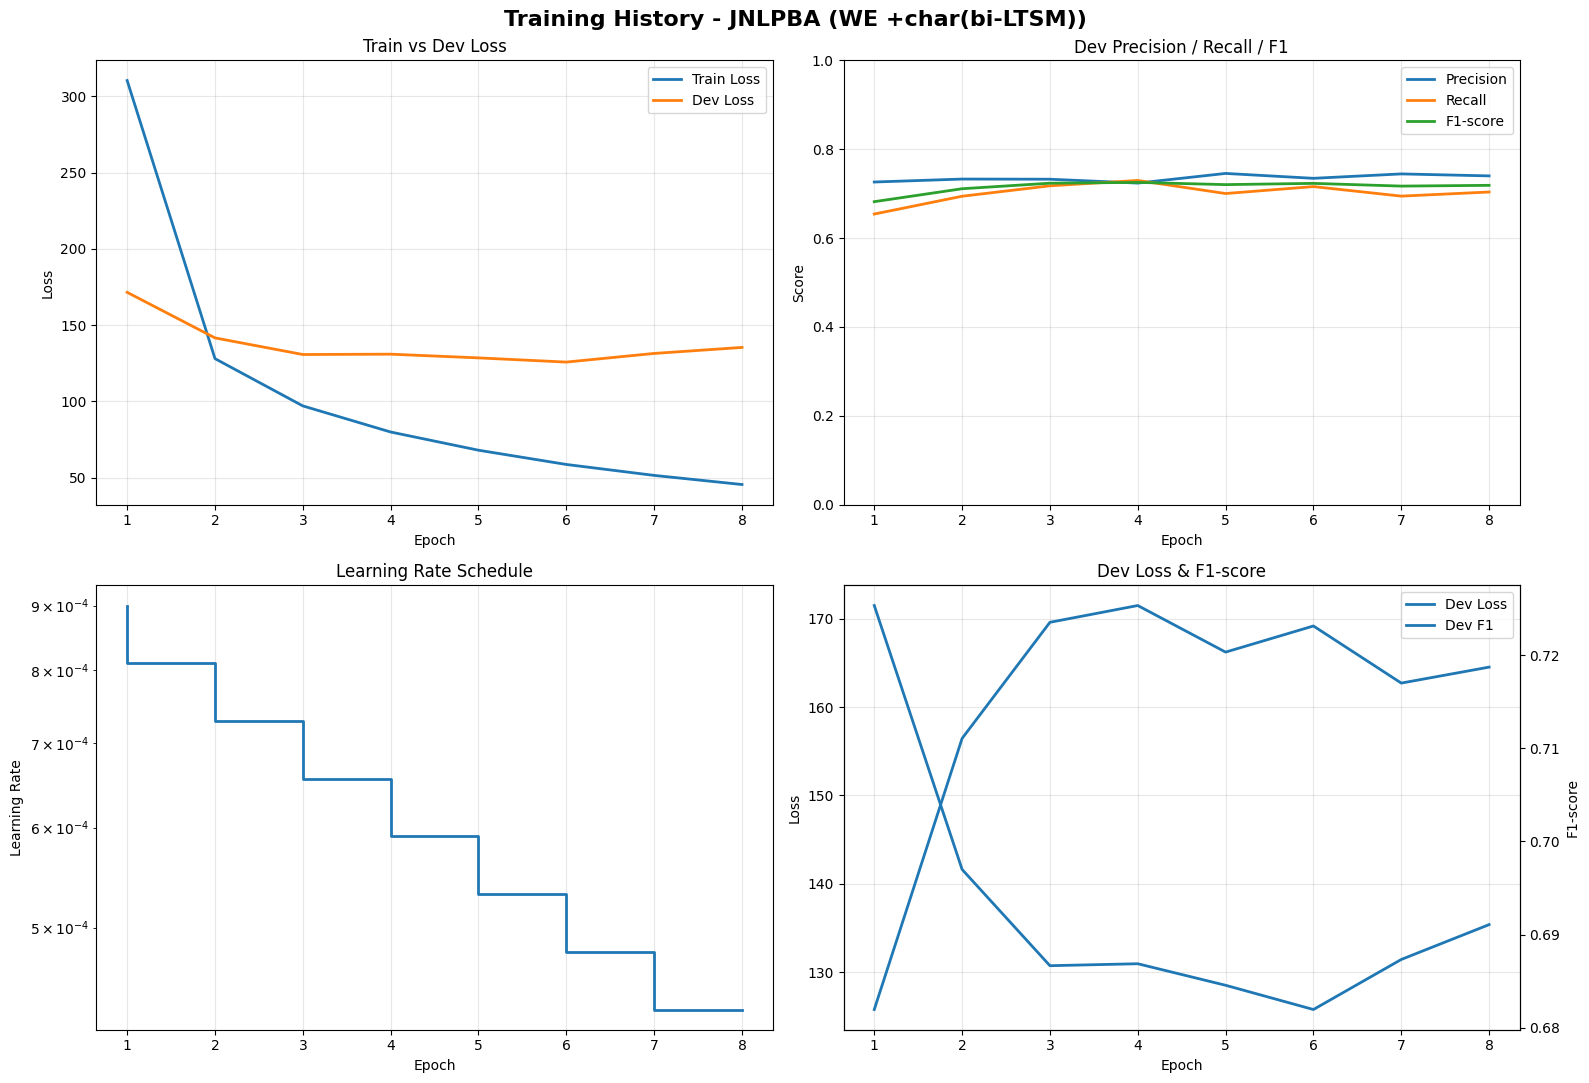


STATISTIQUES FINALES - JNLPBA (WE +char(bi-LTSM))
Meilleur F1 (dev)       : 0.7253
Meilleure Precision(dev): 0.7455
Meilleur Recall (dev)   : 0.7297
Final train loss        : 45.4930
Final dev loss          : 135.3824
Final learning rate     : 0.000430


In [27]:
plot_training_history(history_we_char_bilstm, dataset_name="JNLPBA (WE +char(bi-LTSM))")

In [28]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm/best_model.pt"
model_we_char_bilstm , device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=True,use_attention=False,use_fc_fusion=False
)

test_loader = results_jnlpba['test_loader']
predictions_we_char, targets_we_char = predict_on_test_set(
    model=model_we_char_bilstm ,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm/best_model.pt
Best F1 enregistré: 0.7253
Époque: 3
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O               


Accuracy globale: 0.9247

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 16841
  Unique entity tags in targets: {'B-cell_type', 'B-DNA', 'B-cell_line', 'I-cell_line', 'B-protein', 'I-cell_type', 'I-RNA', 'I-DNA', 'B-RNA', 'I-protein'}
  Unique entity tags in predictions: {'B-cell_type', 'B-DNA', 'B-cell_line', 'I-cell_type', 'B-protein', 'I-cell_line', 'I-RNA', 'I-DNA', 'B-RNA', 'O', 'I-protein'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


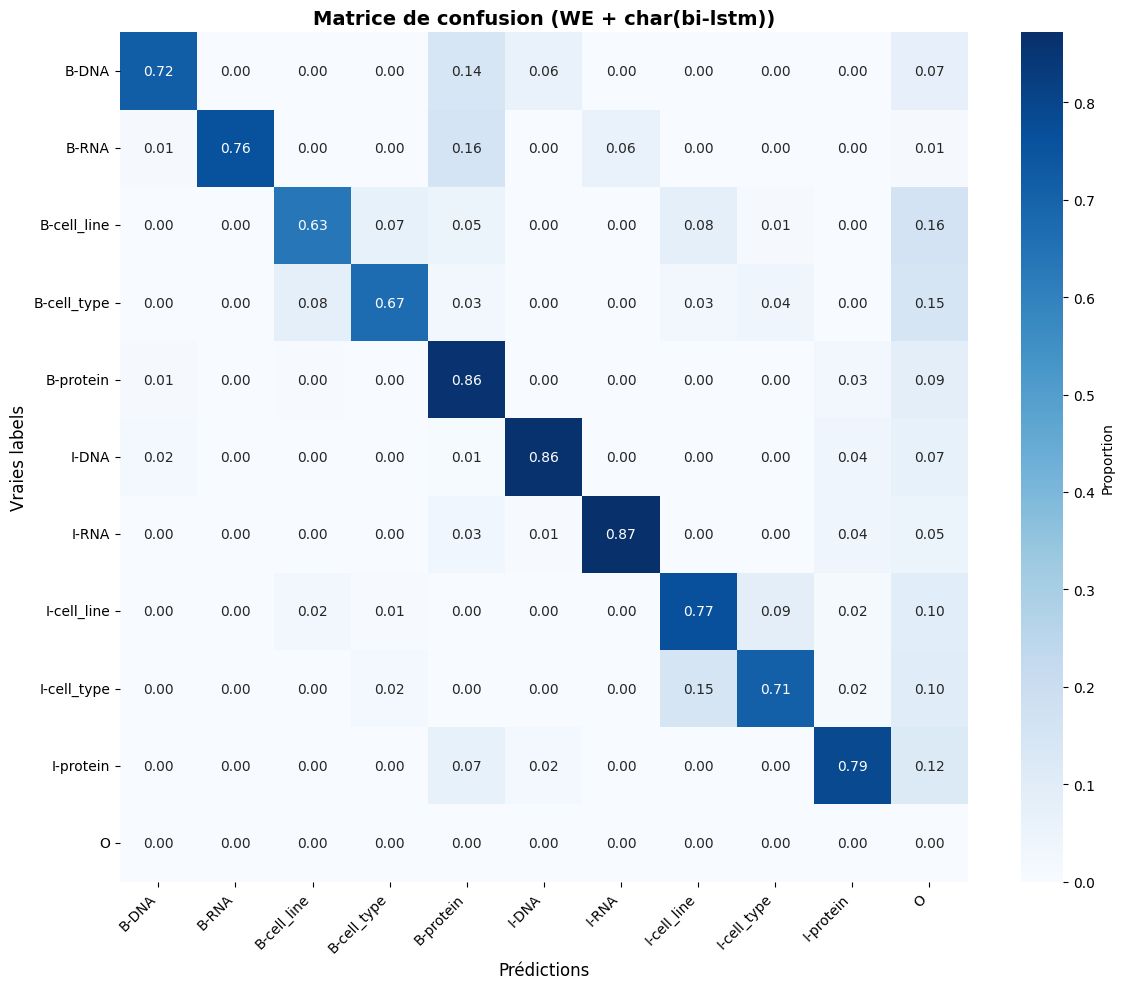

              precision    recall  f1-score   support

       B-DNA       0.87      0.72      0.79       857
       B-RNA       0.88      0.76      0.82        96
 B-cell_line       0.57      0.63      0.60       393
 B-cell_type       0.93      0.67      0.78      1730
   B-protein       0.88      0.86      0.87      4507
       I-DNA       0.89      0.86      0.88      1397
       I-RNA       0.89      0.87      0.88       156
 I-cell_line       0.55      0.77      0.64       792
 I-cell_type       0.92      0.71      0.80      2691
   I-protein       0.93      0.79      0.85      4222
           O       0.00      0.00      0.00         0

    accuracy                           0.78     16841
   macro avg       0.76      0.69      0.72     16841
weighted avg       0.88      0.78      0.82     16841



In [29]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char, predictions_we_char)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char, targets_we_char) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char, targets_we_char) if t != 'O']

if set(predictions_we_char) == set(targets_we_char) or all(isinstance(p, str) for p in predictions_we_char):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char,
        targets=targets_we_char,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(bi-lstm))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char[:10])}")

## Combinaison 4:  WE + char(bi-lstm) + attention

In [11]:
model_we_char_attention, history_we_char_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,024,750


Training: 100%|██████████| 491/491 [16:42<00:00,  2.04s/it]


Epoch 01/40 | Train loss: 338.0653 | Dev loss: 171.9106 | P: 0.7175 R: 0.6731 F1: 0.6918 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6918


Training: 100%|██████████| 491/491 [16:38<00:00,  2.03s/it]


Epoch 02/40 | Train loss: 132.7974 | Dev loss: 147.0735 | P: 0.7328 R: 0.6720 F1: 0.6972 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.6972


Training: 100%|██████████| 491/491 [16:39<00:00,  2.04s/it]


Epoch 03/40 | Train loss: 101.5905 | Dev loss: 136.0940 | P: 0.7323 R: 0.6875 F1: 0.7048 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7048


Training: 100%|██████████| 491/491 [16:35<00:00,  2.03s/it]


Epoch 04/40 | Train loss: 83.2575 | Dev loss: 128.8555 | P: 0.7350 R: 0.6951 F1: 0.7106 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7106


Training: 100%|██████████| 491/491 [16:33<00:00,  2.02s/it]


Epoch 05/40 | Train loss: 71.3135 | Dev loss: 125.5564 | P: 0.7296 R: 0.7181 F1: 0.7228 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7228


Training: 100%|██████████| 491/491 [16:35<00:00,  2.03s/it]


Epoch 06/40 | Train loss: 61.7458 | Dev loss: 127.1225 | P: 0.7429 R: 0.7100 F1: 0.7249 | LR: 0.000531
Meilleur modèle sauvegardé: F1 0.7249


Training: 100%|██████████| 491/491 [16:33<00:00,  2.02s/it]


Epoch 07/40 | Train loss: 54.4740 | Dev loss: 128.2198 | P: 0.7385 R: 0.7111 F1: 0.7235 | LR: 0.000478


Training: 100%|██████████| 491/491 [16:33<00:00,  2.02s/it]


Epoch 08/40 | Train loss: 48.3723 | Dev loss: 130.7729 | P: 0.7447 R: 0.7008 F1: 0.7210 | LR: 0.000430


Training: 100%|██████████| 491/491 [16:33<00:00,  2.02s/it]


Epoch 09/40 | Train loss: 43.0180 | Dev loss: 137.0041 | P: 0.7289 R: 0.7001 F1: 0.7132 | LR: 0.000387


Training: 100%|██████████| 491/491 [16:34<00:00,  2.03s/it]


Epoch 10/40 | Train loss: 38.3528 | Dev loss: 143.2107 | P: 0.7456 R: 0.6876 F1: 0.7139 | LR: 0.000349
Early stopping triggered après 10 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 139.6070
Precision: 0.6617
Recall: 0.6763
F1-score: 0.6665


In [43]:
print_model_layers(model_we_char_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      440,320
attention_layer.W (Linear)     |          256
emission (Linear)              |        6,156
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,024,750


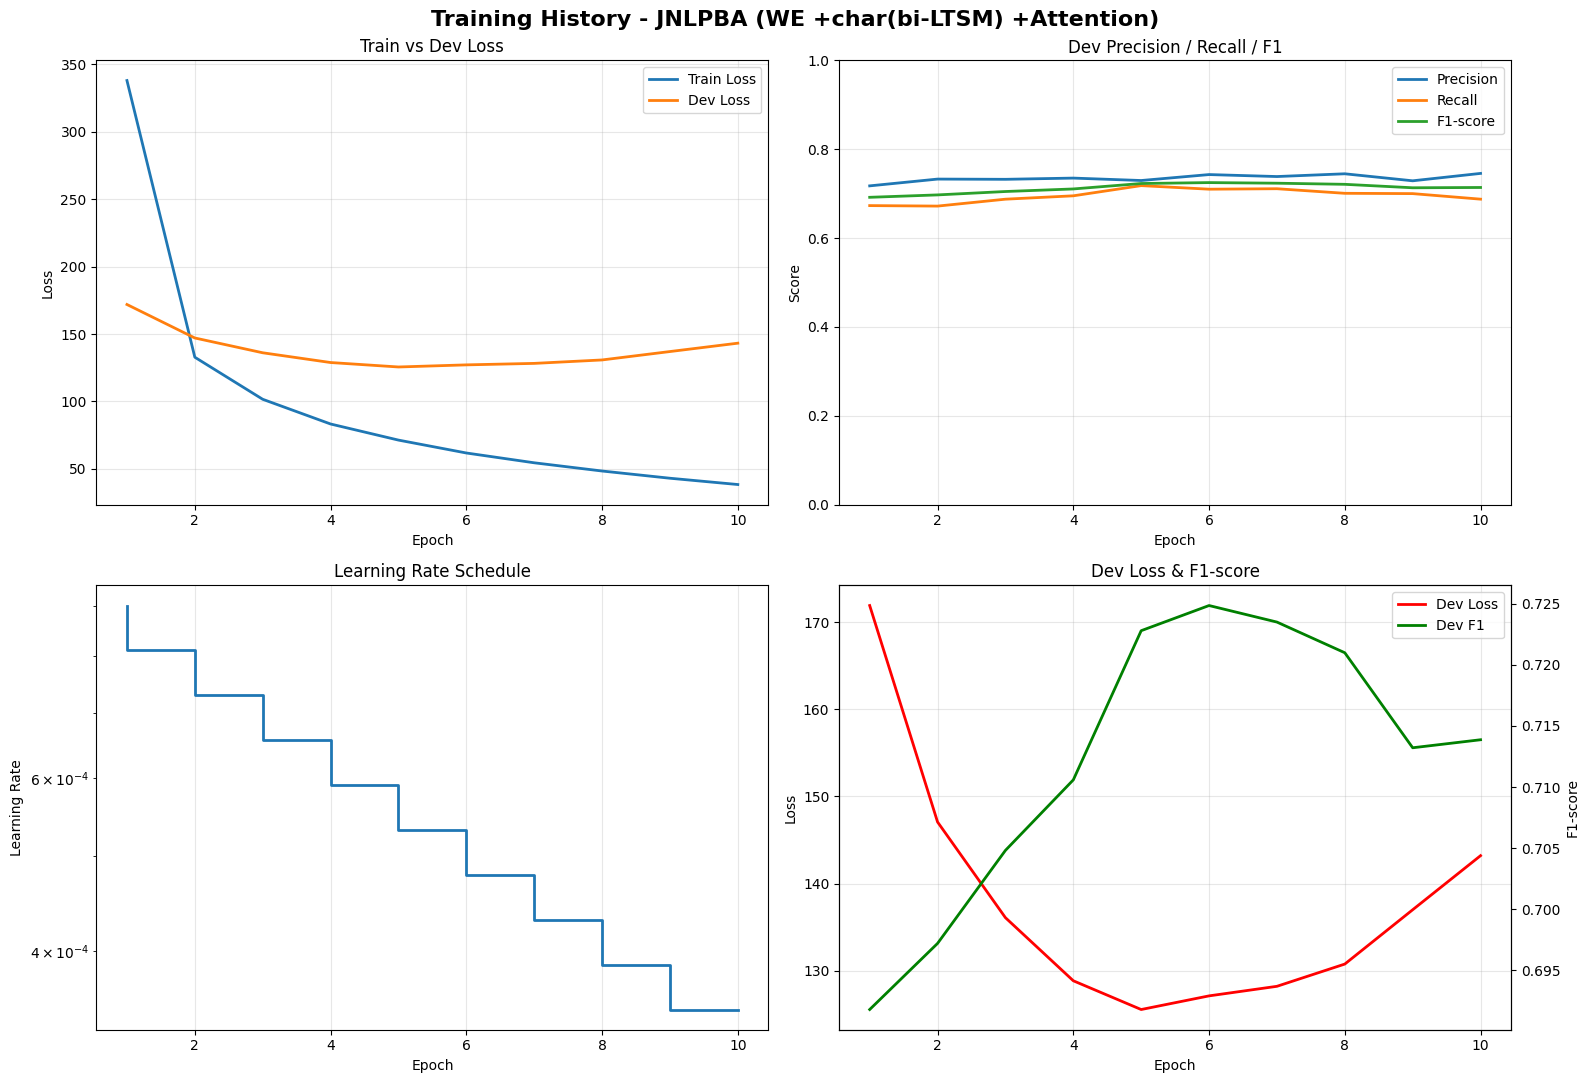


STATISTIQUES FINALES - JNLPBA (WE +char(bi-LTSM) +Attention)
Meilleur F1 (dev)       : 0.7249
Meilleure Precision(dev): 0.7456
Meilleur Recall (dev)   : 0.7181
Final train loss        : 38.3528
Final dev loss          : 143.2107
Final learning rate     : 0.000349


In [44]:
plot_training_history(history_we_char_attention, dataset_name="JNLPBA (WE +char(bi-LTSM) +Attention)")

In [20]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt"
model_we_char_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=True,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_jnlpba['test_loader']
predictions_we_char_attention, targets_we_char_attention = predict_on_test_set(
    model=model_we_char_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt
Best F1 enregistré: 0.7249
Époque: 5
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O     


Accuracy globale: 0.9291

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 16841
  Unique entity tags in targets: {'I-cell_line', 'I-protein', 'B-RNA', 'I-RNA', 'I-DNA', 'B-cell_line', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Unique entity tags in predictions: {'I-cell_line', 'I-protein', 'I-DNA', 'B-RNA', 'I-RNA', 'B-cell_line', 'O', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


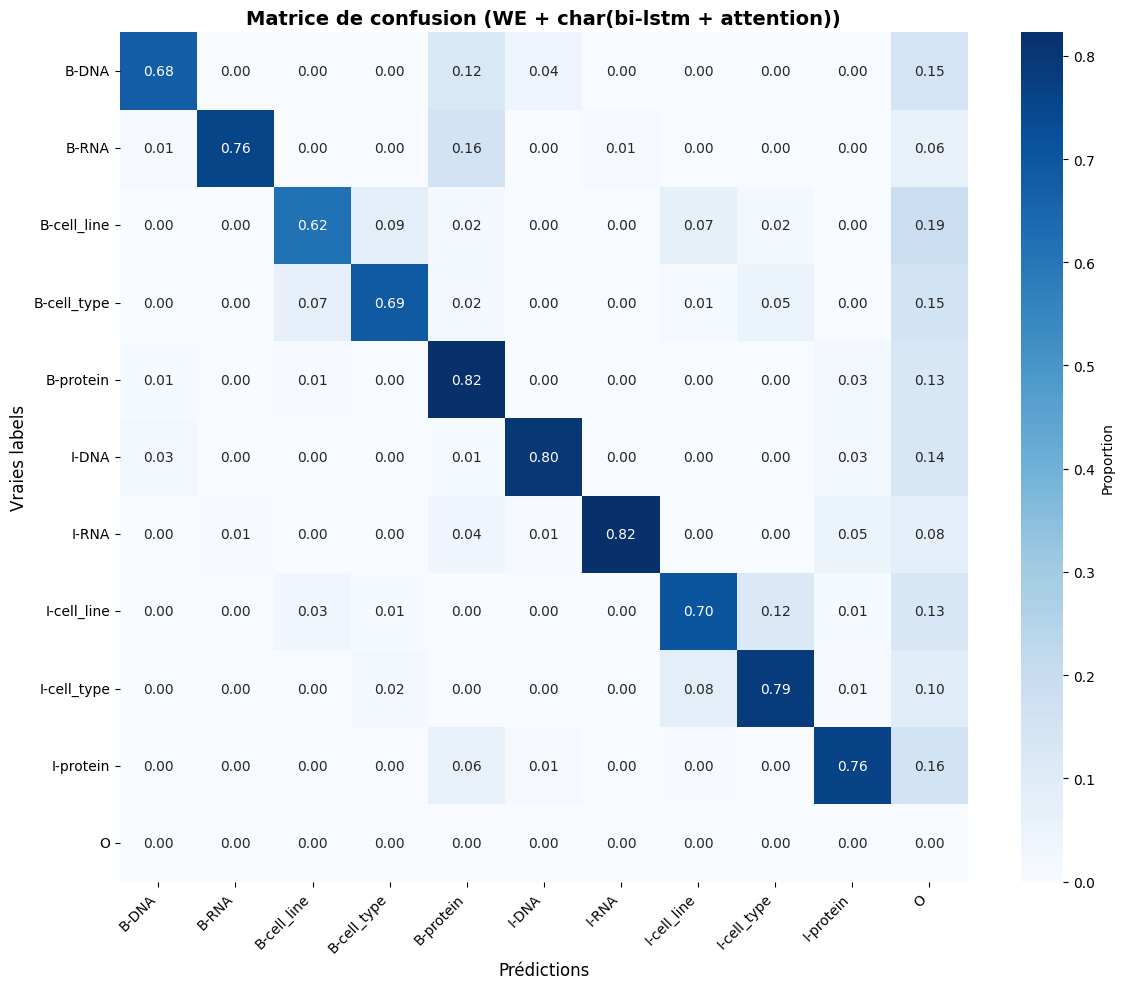

              precision    recall  f1-score   support

       B-DNA       0.88      0.68      0.77       857
       B-RNA       0.86      0.76      0.81        96
 B-cell_line       0.57      0.62      0.59       393
 B-cell_type       0.92      0.69      0.79      1730
   B-protein       0.89      0.82      0.86      4507
       I-DNA       0.93      0.80      0.86      1397
       I-RNA       0.91      0.82      0.86       156
 I-cell_line       0.66      0.70      0.68       792
 I-cell_type       0.91      0.79      0.84      2691
   I-protein       0.94      0.76      0.84      4222
           O       0.00      0.00      0.00         0

    accuracy                           0.77     16841
   macro avg       0.77      0.68      0.72     16841
weighted avg       0.89      0.77      0.82     16841



In [23]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_attention, predictions_we_char_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char_attention, targets_we_char_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char_attention, targets_we_char_attention) if t != 'O']

if set(predictions_we_char_attention) == set(targets_we_char_attention) or all(isinstance(p, str) for p in predictions_we_char_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_attention,
        targets=targets_we_char_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(bi-lstm + attention))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_attention[:10])}")

## Combinaison 5:  WE + char(cnn)

In [24]:
model_we_char_cnn, history_we_char_cnn = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=False,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,000,622


Training: 100%|██████████| 491/491 [02:03<00:00,  3.99it/s]


Epoch 01/40 | Train loss: 310.1096 | Dev loss: 169.0406 | P: 0.7201 R: 0.6722 F1: 0.6917 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6917


Training: 100%|██████████| 491/491 [02:03<00:00,  3.97it/s]


Epoch 02/40 | Train loss: 130.8380 | Dev loss: 143.5513 | P: 0.7466 R: 0.6778 F1: 0.7077 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7077


Training: 100%|██████████| 491/491 [02:13<00:00,  3.68it/s]


Epoch 03/40 | Train loss: 100.5350 | Dev loss: 133.7648 | P: 0.7411 R: 0.7135 F1: 0.7244 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7244


Training: 100%|██████████| 491/491 [02:01<00:00,  4.03it/s]


Epoch 04/40 | Train loss: 82.8450 | Dev loss: 128.3751 | P: 0.7422 R: 0.7063 F1: 0.7213 | LR: 0.000656


Training: 100%|██████████| 491/491 [02:05<00:00,  3.93it/s]


Epoch 05/40 | Train loss: 70.5975 | Dev loss: 126.0091 | P: 0.7437 R: 0.7080 F1: 0.7238 | LR: 0.000590


Training: 100%|██████████| 491/491 [02:05<00:00,  3.93it/s]


Epoch 06/40 | Train loss: 61.5979 | Dev loss: 127.5080 | P: 0.7409 R: 0.7102 F1: 0.7245 | LR: 0.000531
Meilleur modèle sauvegardé: F1 0.7245


Training: 100%|██████████| 491/491 [02:04<00:00,  3.93it/s]


Epoch 07/40 | Train loss: 54.4889 | Dev loss: 127.8245 | P: 0.7403 R: 0.6975 F1: 0.7172 | LR: 0.000478


Training: 100%|██████████| 491/491 [02:06<00:00,  3.89it/s]


Epoch 08/40 | Train loss: 48.4704 | Dev loss: 128.5887 | P: 0.7346 R: 0.7152 F1: 0.7234 | LR: 0.000430


Training: 100%|██████████| 491/491 [02:16<00:00,  3.61it/s]


Epoch 09/40 | Train loss: 43.3363 | Dev loss: 136.9914 | P: 0.7312 R: 0.7004 F1: 0.7127 | LR: 0.000387


Training: 100%|██████████| 491/491 [02:02<00:00,  4.02it/s]


Epoch 10/40 | Train loss: 38.5381 | Dev loss: 137.6157 | P: 0.7350 R: 0.7057 F1: 0.7183 | LR: 0.000349
Early stopping triggered après 10 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 141.9015
Precision: 0.6563
Recall: 0.6796
F1-score: 0.6633


In [25]:
print_model_layers(model_we_char_cnn)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
context_lstm (LSTM)            |      436,224
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,000,622


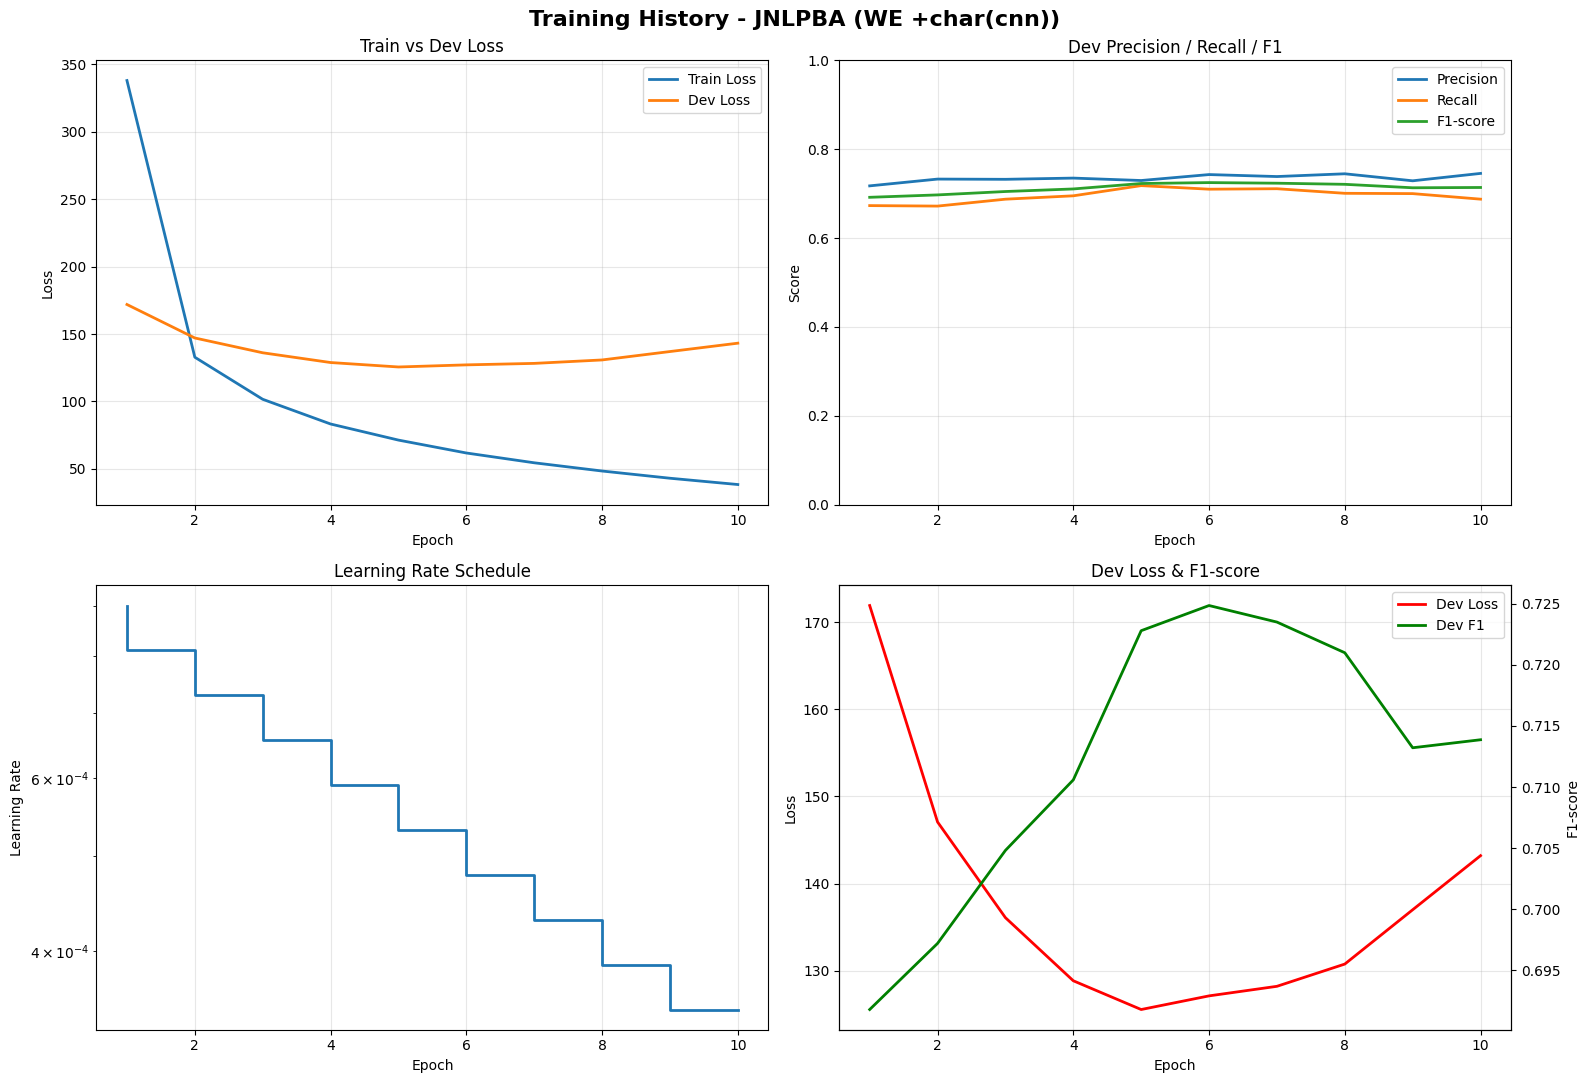


STATISTIQUES FINALES - JNLPBA (WE +char(cnn))
Meilleur F1 (dev)       : 0.7249
Meilleure Precision(dev): 0.7456
Meilleur Recall (dev)   : 0.7181
Final train loss        : 38.3528
Final dev loss          : 143.2107
Final learning rate     : 0.000349


In [45]:
plot_training_history(history_we_char_attention, dataset_name="JNLPBA (WE +char(cnn))")

In [27]:
model_path = "./checkpoints/JNLPBA/WE_char_cnn/best_model.pt"
model_we_char_cnn, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char_cnn, targets_we_char_cnn = predict_on_test_set(
    model=model_we_char_cnn,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_cnn/best_model.pt
Best F1 enregistré: 0.7245
Époque: 5
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-protein          incorrect
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O                  co


Accuracy globale: 0.9284

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 16841
  Unique entity tags in targets: {'I-cell_line', 'I-protein', 'B-RNA', 'I-RNA', 'I-DNA', 'B-cell_line', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Unique entity tags in predictions: {'I-cell_line', 'I-protein', 'I-DNA', 'B-RNA', 'I-RNA', 'B-cell_line', 'O', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


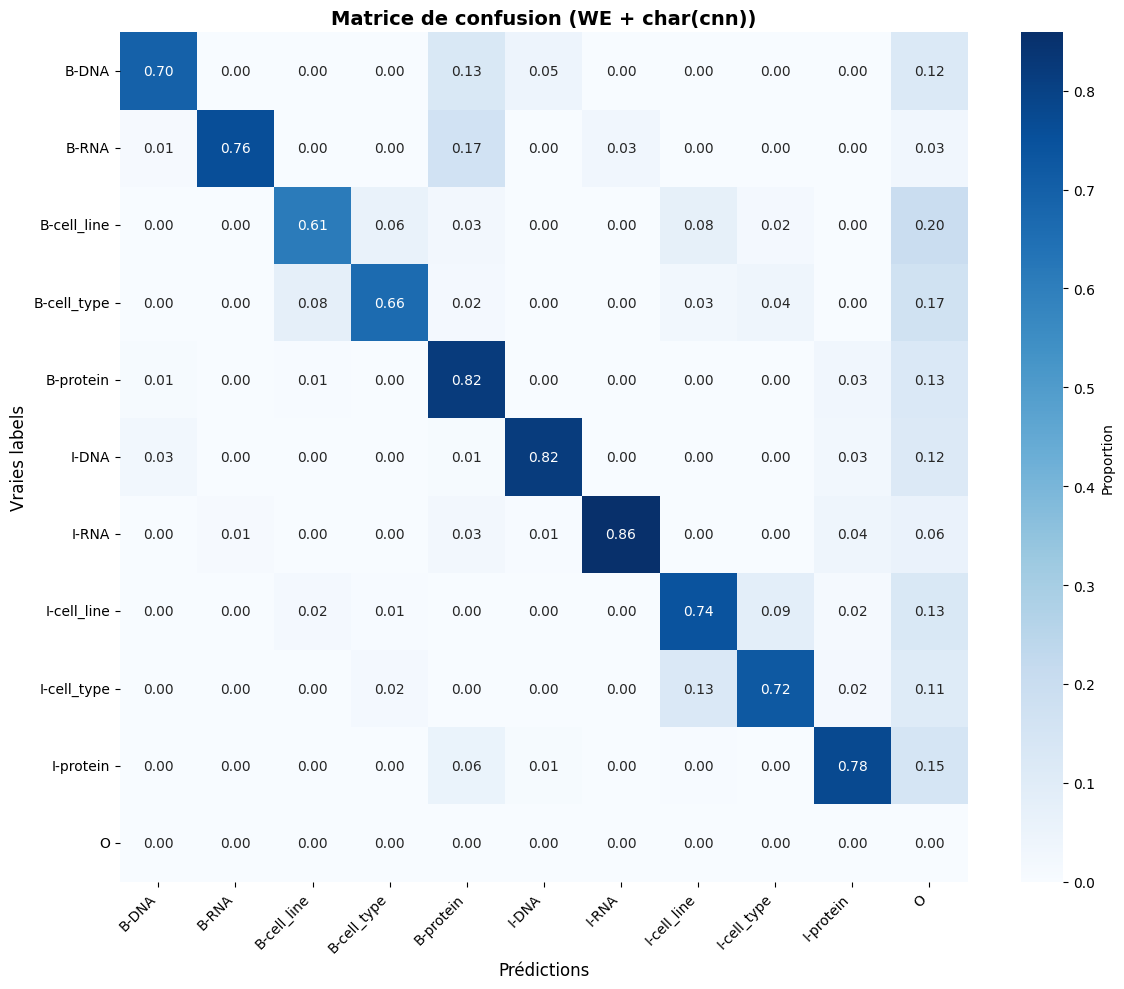

              precision    recall  f1-score   support

       B-DNA       0.87      0.70      0.77       857
       B-RNA       0.86      0.76      0.81        96
 B-cell_line       0.57      0.61      0.59       393
 B-cell_type       0.93      0.66      0.77      1730
   B-protein       0.90      0.82      0.86      4507
       I-DNA       0.93      0.82      0.87      1397
       I-RNA       0.91      0.86      0.88       156
 I-cell_line       0.57      0.74      0.65       792
 I-cell_type       0.93      0.72      0.81      2691
   I-protein       0.93      0.78      0.85      4222
           O       0.00      0.00      0.00         0

    accuracy                           0.76     16841
   macro avg       0.76      0.68      0.71     16841
weighted avg       0.89      0.76      0.82     16841



In [28]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_cnn, predictions_we_char_cnn)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char_cnn, targets_we_char_cnn) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char_cnn, targets_we_char_cnn) if t != 'O']

if set(predictions_we_char_cnn) == set(targets_we_char_cnn) or all(isinstance(p, str) for p in predictions_we_char_cnn):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_cnn,
        targets=targets_we_char_cnn,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_cnn[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_cnn[:10])}")

## Combinaison 6:  WE + char(cnn) + attention

In [29]:
model_we_char_cnn_attention, history_we_char_cnn_attention = run_pipeline(
     dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,003,950


Training: 100%|██████████| 491/491 [08:11<00:00,  1.00s/it]


Epoch 01/40 | Train loss: 337.8383 | Dev loss: 184.2517 | P: 0.7257 R: 0.6171 F1: 0.6565 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6565


Training: 100%|██████████| 491/491 [08:11<00:00,  1.00s/it]


Epoch 02/40 | Train loss: 138.3219 | Dev loss: 151.6303 | P: 0.7094 R: 0.7143 F1: 0.7079 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7079


Training: 100%|██████████| 491/491 [08:14<00:00,  1.01s/it]


Epoch 03/40 | Train loss: 105.4174 | Dev loss: 132.4534 | P: 0.7391 R: 0.7016 F1: 0.7191 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7191


Training: 100%|██████████| 491/491 [08:11<00:00,  1.00s/it]


Epoch 04/40 | Train loss: 86.7044 | Dev loss: 125.9417 | P: 0.7382 R: 0.7102 F1: 0.7233 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7233


Training: 100%|██████████| 491/491 [08:12<00:00,  1.00s/it]


Epoch 05/40 | Train loss: 74.4094 | Dev loss: 124.5188 | P: 0.7442 R: 0.7036 F1: 0.7226 | LR: 0.000590


Training: 100%|██████████| 491/491 [09:51<00:00,  1.20s/it]


Epoch 06/40 | Train loss: 64.5010 | Dev loss: 124.1893 | P: 0.7402 R: 0.7100 F1: 0.7237 | LR: 0.000531
Meilleur modèle sauvegardé: F1 0.7237


Training: 100%|██████████| 491/491 [09:49<00:00,  1.20s/it]


Epoch 07/40 | Train loss: 57.0398 | Dev loss: 124.4190 | P: 0.7278 R: 0.7278 F1: 0.7268 | LR: 0.000478
Meilleur modèle sauvegardé: F1 0.7268


Training: 100%|██████████| 491/491 [09:29<00:00,  1.16s/it]


Epoch 08/40 | Train loss: 51.0952 | Dev loss: 127.1263 | P: 0.7421 R: 0.6995 F1: 0.7195 | LR: 0.000430


Training: 100%|██████████| 491/491 [08:32<00:00,  1.04s/it]


Epoch 09/40 | Train loss: 45.5828 | Dev loss: 132.1833 | P: 0.7217 R: 0.7170 F1: 0.7184 | LR: 0.000387


Training: 100%|██████████| 491/491 [09:07<00:00,  1.11s/it]


Epoch 10/40 | Train loss: 41.3215 | Dev loss: 135.5368 | P: 0.7326 R: 0.7023 F1: 0.7154 | LR: 0.000349


Training: 100%|██████████| 491/491 [09:23<00:00,  1.15s/it]


Epoch 11/40 | Train loss: 37.3719 | Dev loss: 138.9504 | P: 0.7311 R: 0.6992 F1: 0.7133 | LR: 0.000314
Early stopping triggered après 11 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 141.8019
Precision: 0.6389
Recall: 0.6831
F1-score: 0.6566


In [30]:
print_model_layers(model_we_char_cnn_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
context_lstm (LSTM)            |      436,224
attention_layer.W (Linear)     |          256
emission (Linear)              |        6,156
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,003,950


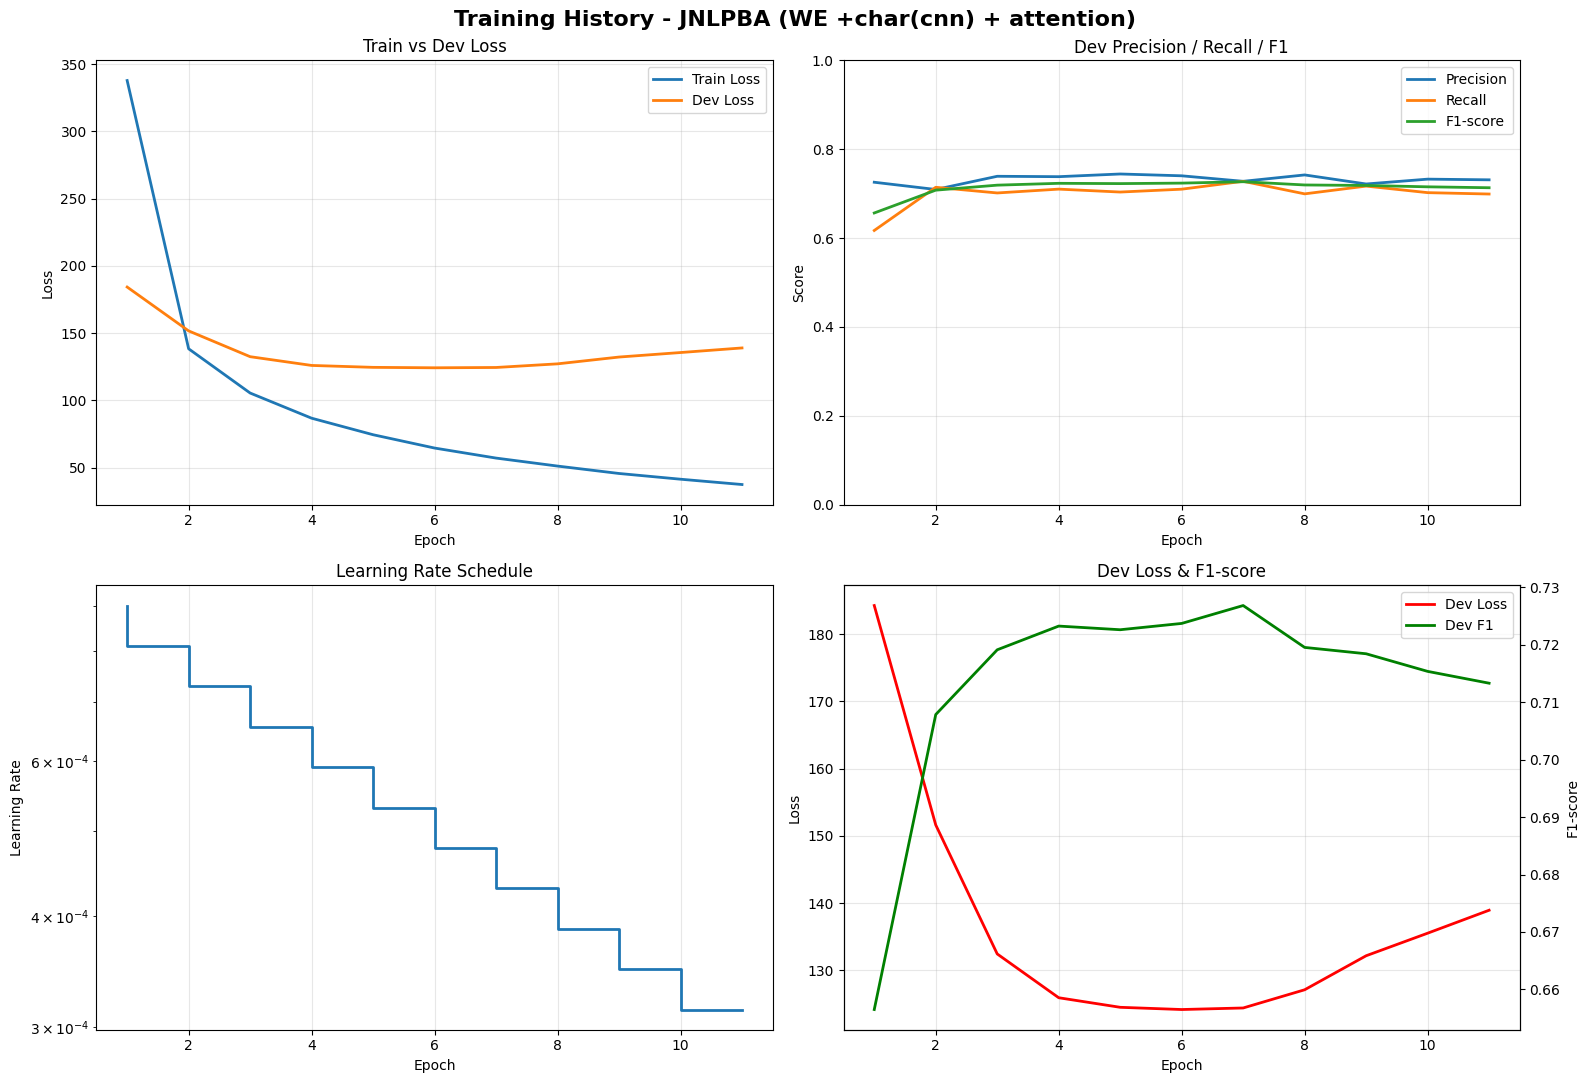


STATISTIQUES FINALES - JNLPBA (WE +char(cnn) + attention)
Meilleur F1 (dev)       : 0.7268
Meilleure Precision(dev): 0.7442
Meilleur Recall (dev)   : 0.7278
Final train loss        : 37.3719
Final dev loss          : 138.9504
Final learning rate     : 0.000314


In [46]:
plot_training_history(history_we_char_cnn_attention, dataset_name="JNLPBA (WE +char(cnn) + attention)")

In [32]:
model_path = "./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt"
model_we_char_cnn_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char_cnn_attention, targets_we_char_cnn_attention = predict_on_test_set(
    model=model_we_char_cnn_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt
Best F1 enregistré: 0.7268
Époque: 6
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O        


Accuracy globale: 0.9268

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 16841
  Unique entity tags in targets: {'I-cell_line', 'I-protein', 'B-RNA', 'I-RNA', 'I-DNA', 'B-cell_line', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Unique entity tags in predictions: {'I-cell_line', 'I-protein', 'I-DNA', 'B-RNA', 'I-RNA', 'B-cell_line', 'O', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


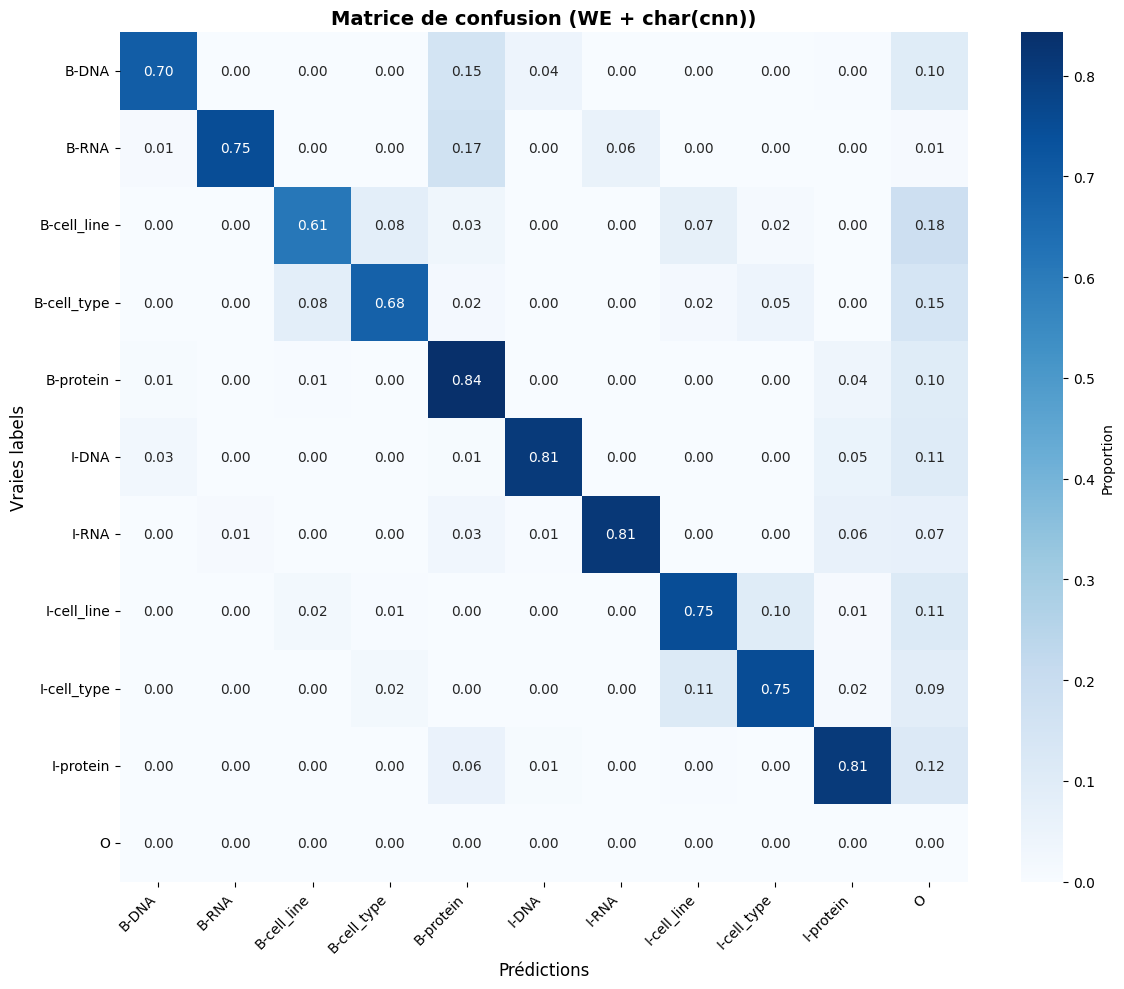

              precision    recall  f1-score   support

       B-DNA       0.89      0.70      0.78       857
       B-RNA       0.87      0.75      0.80        96
 B-cell_line       0.55      0.61      0.58       393
 B-cell_type       0.92      0.68      0.78      1730
   B-protein       0.89      0.84      0.87      4507
       I-DNA       0.94      0.81      0.87      1397
       I-RNA       0.85      0.81      0.83       156
 I-cell_line       0.60      0.75      0.67       792
 I-cell_type       0.92      0.75      0.83      2691
   I-protein       0.92      0.81      0.86      4222
           O       0.00      0.00      0.00         0

    accuracy                           0.78     16841
   macro avg       0.76      0.68      0.72     16841
weighted avg       0.89      0.78      0.83     16841



In [33]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_cnn_attention, predictions_we_char_cnn_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char_cnn_attention, targets_we_char_cnn_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char_cnn_attention, targets_we_char_cnn_attention) if t != 'O']

if set(predictions_we_char_cnn_attention) == set(targets_we_char_cnn_attention) or all(isinstance(p, str) for p in predictions_we_char_cnn_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_cnn_attention,
        targets=targets_we_char_cnn_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_cnn_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_cnn_attention[:10])}")

## Combinaison 7: WE + char(cnn, bilstm)

In [34]:
model_we_char_cnn_bilstm, history_we_char_cnn_bilstm = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,148,072


Training: 100%|██████████| 491/491 [02:34<00:00,  3.18it/s]


Epoch 01/40 | Train loss: 316.3727 | Dev loss: 171.4713 | P: 0.7340 R: 0.6354 F1: 0.6743 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6743


Training: 100%|██████████| 491/491 [03:33<00:00,  2.30it/s]


Epoch 02/40 | Train loss: 131.2948 | Dev loss: 143.3279 | P: 0.7109 R: 0.7220 F1: 0.7151 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7151


Training: 100%|██████████| 491/491 [02:44<00:00,  2.98it/s]


Epoch 03/40 | Train loss: 99.5883 | Dev loss: 135.1299 | P: 0.7511 R: 0.6838 F1: 0.7146 | LR: 0.000729


Training: 100%|██████████| 491/491 [04:00<00:00,  2.05it/s]


Epoch 04/40 | Train loss: 81.9480 | Dev loss: 125.9223 | P: 0.7386 R: 0.7101 F1: 0.7232 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7232


Training: 100%|██████████| 491/491 [03:00<00:00,  2.71it/s]


Epoch 05/40 | Train loss: 70.3875 | Dev loss: 127.9125 | P: 0.7496 R: 0.6857 F1: 0.7139 | LR: 0.000590


Training: 100%|██████████| 491/491 [05:14<00:00,  1.56it/s]


Epoch 06/40 | Train loss: 61.0717 | Dev loss: 125.7540 | P: 0.7513 R: 0.6997 F1: 0.7224 | LR: 0.000531


Training: 100%|██████████| 491/491 [02:34<00:00,  3.18it/s]


Epoch 07/40 | Train loss: 53.8487 | Dev loss: 127.2690 | P: 0.7423 R: 0.7019 F1: 0.7209 | LR: 0.000478


Training: 100%|██████████| 491/491 [03:25<00:00,  2.39it/s]


Epoch 08/40 | Train loss: 48.0102 | Dev loss: 127.4058 | P: 0.7408 R: 0.7134 F1: 0.7254 | LR: 0.000430
Meilleur modèle sauvegardé: F1 0.7254


Training: 100%|██████████| 491/491 [04:01<00:00,  2.04it/s]


Epoch 09/40 | Train loss: 42.8655 | Dev loss: 129.5904 | P: 0.7315 R: 0.7198 F1: 0.7242 | LR: 0.000387


Training: 100%|██████████| 491/491 [03:19<00:00,  2.47it/s]


Epoch 10/40 | Train loss: 38.5716 | Dev loss: 135.1153 | P: 0.7316 R: 0.7108 F1: 0.7201 | LR: 0.000349


Training: 100%|██████████| 491/491 [02:27<00:00,  3.33it/s]


Epoch 11/40 | Train loss: 34.8304 | Dev loss: 138.1923 | P: 0.7452 R: 0.6991 F1: 0.7194 | LR: 0.000314


Training: 100%|██████████| 491/491 [04:53<00:00,  1.68it/s]


Epoch 12/40 | Train loss: 31.3307 | Dev loss: 141.7620 | P: 0.7350 R: 0.6995 F1: 0.7156 | LR: 0.000282
Early stopping triggered après 12 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 146.6748
Precision: 0.6476
Recall: 0.6761
F1-score: 0.6554


In [35]:
print_model_layers(model_we_char_cnn_bilstm)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      538,624
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,148,072


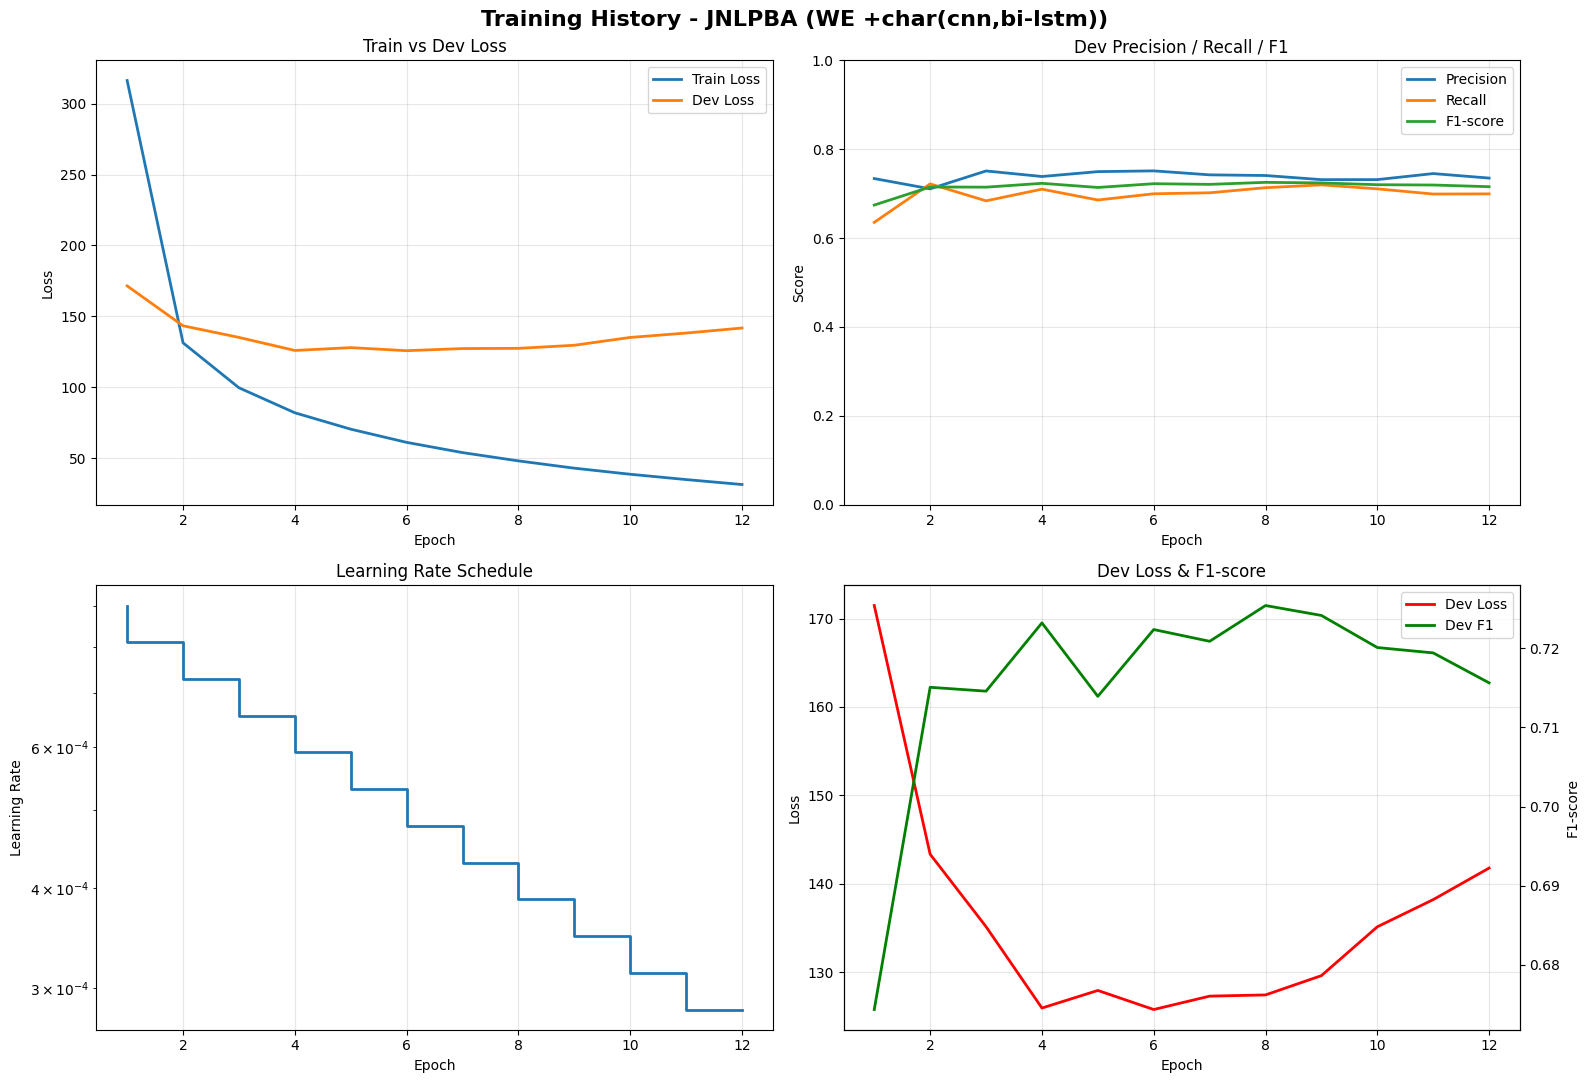


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bi-lstm))
Meilleur F1 (dev)       : 0.7254
Meilleure Precision(dev): 0.7513
Meilleur Recall (dev)   : 0.7220
Final train loss        : 31.3307
Final dev loss          : 141.7620
Final learning rate     : 0.000282


In [47]:
plot_training_history(history_we_char_cnn_bilstm, dataset_name="JNLPBA (WE +char(cnn,bi-lstm))")

In [37]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt"
model_we_char__bilstm_cnn, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=False,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn = predict_on_test_set(
    model=model_we_char__bilstm_cnn,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt
Best F1 enregistré: 0.7254
Époque: 7
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O           


Accuracy globale: 0.9265

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 16841
  Unique entity tags in targets: {'I-cell_line', 'I-protein', 'B-RNA', 'I-RNA', 'I-DNA', 'B-cell_line', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Unique entity tags in predictions: {'I-cell_line', 'I-protein', 'I-DNA', 'B-RNA', 'I-RNA', 'B-cell_line', 'O', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


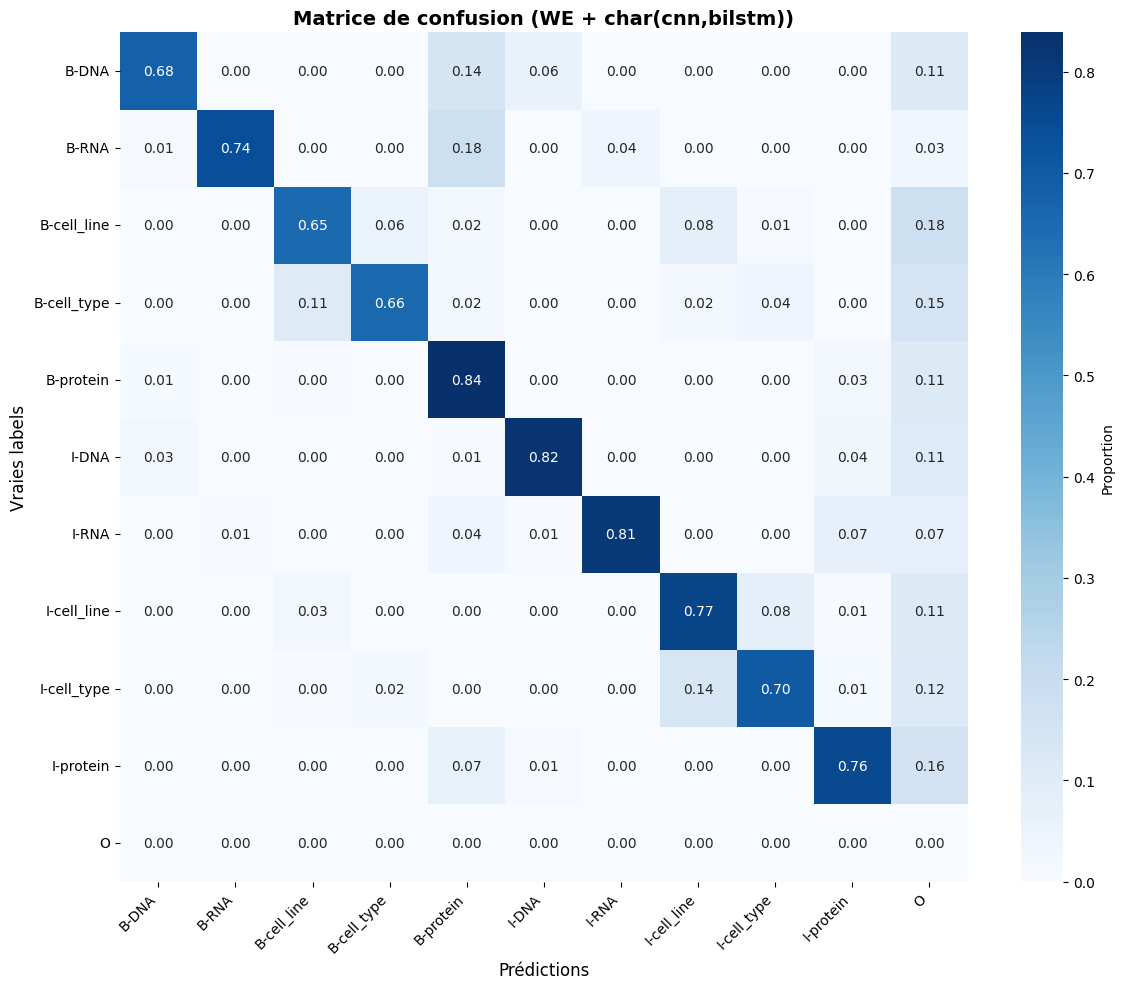

              precision    recall  f1-score   support

       B-DNA       0.88      0.68      0.77       857
       B-RNA       0.86      0.74      0.79        96
 B-cell_line       0.52      0.65      0.58       393
 B-cell_type       0.92      0.66      0.77      1730
   B-protein       0.89      0.84      0.86      4507
       I-DNA       0.92      0.82      0.87      1397
       I-RNA       0.89      0.81      0.85       156
 I-cell_line       0.58      0.77      0.66       792
 I-cell_type       0.92      0.70      0.80      2691
   I-protein       0.93      0.76      0.84      4222
           O       0.00      0.00      0.00         0

    accuracy                           0.76     16841
   macro avg       0.76      0.68      0.71     16841
weighted avg       0.89      0.76      0.81     16841



In [38]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn, predictions_we_char__bilstm_cnn)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn) if t != 'O']

if set(predictions_we_char__bilstm_cnn) == set(targets_we_char__bilstm_cnn) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn,
        targets=targets_we_char__bilstm_cnn,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn[:10])}")

## Combinaison 8: WE + char(cnn, bilstm) + attention

In [39]:
model_we_char_cnn_bilstm_attention, history_we_char_cnn_bilstm_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,151,400


Training: 100%|██████████| 491/491 [17:03<00:00,  2.08s/it]


Epoch 01/40 | Train loss: 329.4715 | Dev loss: 170.1391 | P: 0.7114 R: 0.6594 F1: 0.6812 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6812


Training: 100%|██████████| 491/491 [16:13<00:00,  1.98s/it]


Epoch 02/40 | Train loss: 134.7441 | Dev loss: 141.3942 | P: 0.7232 R: 0.7100 F1: 0.7139 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7139


Training: 100%|██████████| 491/491 [16:40<00:00,  2.04s/it]


Epoch 03/40 | Train loss: 103.0828 | Dev loss: 135.4289 | P: 0.7520 R: 0.6689 F1: 0.7055 | LR: 0.000729


Training: 100%|██████████| 491/491 [16:46<00:00,  2.05s/it]


Epoch 04/40 | Train loss: 84.4268 | Dev loss: 129.8775 | P: 0.7156 R: 0.7352 F1: 0.7235 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7235


Training: 100%|██████████| 491/491 [17:19<00:00,  2.12s/it]


Epoch 05/40 | Train loss: 71.8321 | Dev loss: 123.8348 | P: 0.7486 R: 0.7041 F1: 0.7242 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7242


Training: 100%|██████████| 491/491 [16:51<00:00,  2.06s/it]


Epoch 06/40 | Train loss: 62.8688 | Dev loss: 121.0375 | P: 0.7386 R: 0.7242 F1: 0.7299 | LR: 0.000531
Meilleur modèle sauvegardé: F1 0.7299


Training: 100%|██████████| 491/491 [16:56<00:00,  2.07s/it]


Epoch 07/40 | Train loss: 55.6547 | Dev loss: 127.3411 | P: 0.7460 R: 0.6658 F1: 0.6989 | LR: 0.000478


Training: 100%|██████████| 491/491 [18:26<00:00,  2.25s/it]


Epoch 08/40 | Train loss: 49.9716 | Dev loss: 124.9583 | P: 0.7314 R: 0.7194 F1: 0.7242 | LR: 0.000430


Training: 100%|██████████| 491/491 [17:08<00:00,  2.09s/it]


Epoch 09/40 | Train loss: 44.5598 | Dev loss: 128.2990 | P: 0.7093 R: 0.7315 F1: 0.7184 | LR: 0.000387


Training: 100%|██████████| 491/491 [16:59<00:00,  2.08s/it]


Epoch 10/40 | Train loss: 40.2259 | Dev loss: 130.6468 | P: 0.7298 R: 0.7157 F1: 0.7213 | LR: 0.000349
Early stopping triggered après 10 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 134.0280
Precision: 0.6500
Recall: 0.6846
F1-score: 0.6644


In [ ]:
print_model_layers(model_we_char_cnn_bilstm_attention)

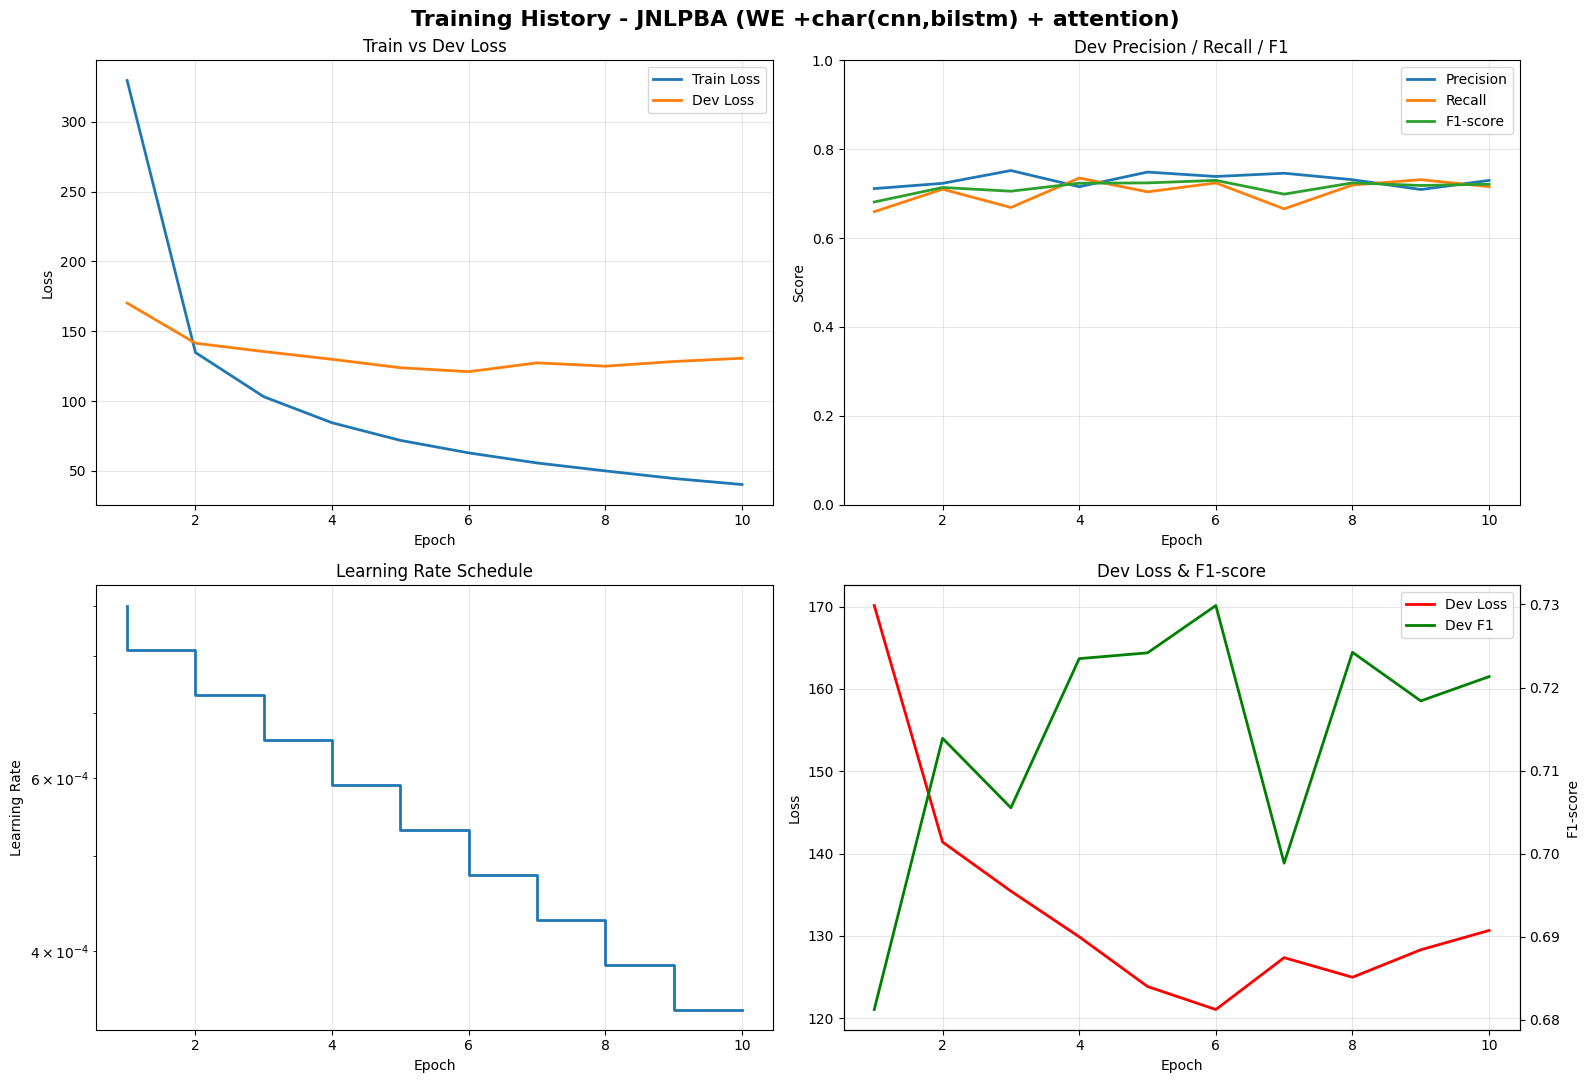


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bilstm) + attention)
Meilleur F1 (dev)       : 0.7299
Meilleure Precision(dev): 0.7520
Meilleur Recall (dev)   : 0.7352
Final train loss        : 40.2259
Final dev loss          : 130.6468
Final learning rate     : 0.000349


In [48]:
plot_training_history(history_we_char_cnn_bilstm_attention, dataset_name="JNLPBA (WE +char(cnn,bilstm) + attention)")

In [49]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt"
model_we_char__bilstm_cnn_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt
Best F1 enregistré: 0.7299
Époque: 5
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O 


Accuracy globale: 0.9291

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 16841
  Unique entity tags in targets: {'I-cell_line', 'I-protein', 'B-RNA', 'I-RNA', 'I-DNA', 'B-cell_line', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Unique entity tags in predictions: {'I-cell_line', 'I-protein', 'I-DNA', 'B-RNA', 'I-RNA', 'B-cell_line', 'O', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


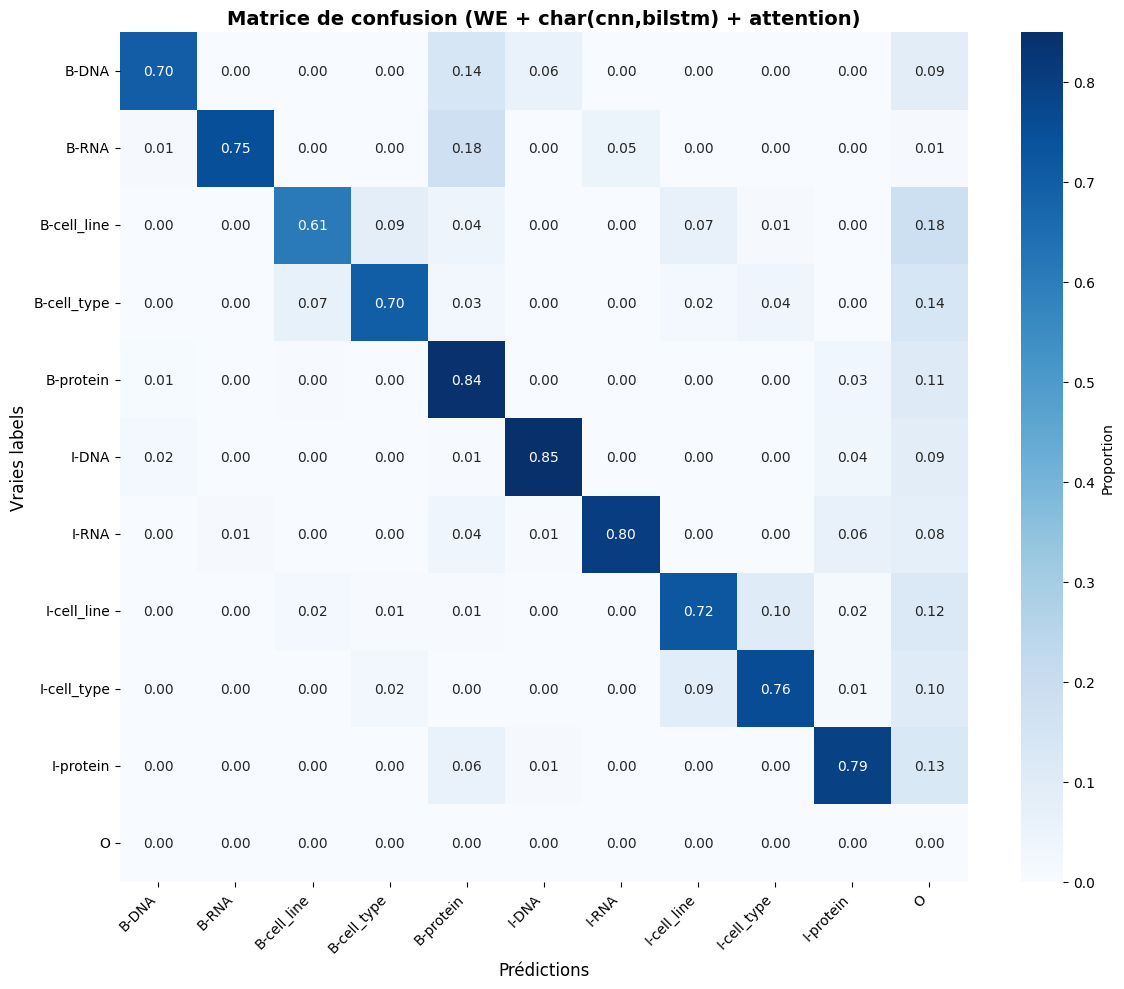

              precision    recall  f1-score   support

       B-DNA       0.89      0.70      0.79       857
       B-RNA       0.85      0.75      0.80        96
 B-cell_line       0.61      0.61      0.61       393
 B-cell_type       0.91      0.70      0.79      1730
   B-protein       0.89      0.84      0.86      4507
       I-DNA       0.91      0.85      0.88      1397
       I-RNA       0.89      0.80      0.84       156
 I-cell_line       0.63      0.72      0.67       792
 I-cell_type       0.93      0.76      0.83      2691
   I-protein       0.93      0.79      0.85      4222
           O       0.00      0.00      0.00         0

    accuracy                           0.78     16841
   macro avg       0.77      0.68      0.72     16841
weighted avg       0.89      0.78      0.83     16841



In [50]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention, predictions_we_char__bilstm_cnn_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention) if t != 'O']

if set(predictions_we_char__bilstm_cnn_attention) == set(targets_we_char__bilstm_cnn_attention) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_attention,
        targets=targets_we_char__bilstm_cnn_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention[:10])}")

## Combinaison 9 : WE + char(cnn, bilstm) + fully connected network

In [51]:
model_we_char_cnn_bilstm_fc, history_we_char_cnn_bilstm_fc = run_pipeline(
     dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=True,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,026,768


Training: 100%|██████████| 491/491 [02:22<00:00,  3.43it/s]


Epoch 01/40 | Train loss: 333.6901 | Dev loss: 175.2907 | P: 0.7107 R: 0.6636 F1: 0.6809 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6809


Training: 100%|██████████| 491/491 [02:40<00:00,  3.05it/s]


Epoch 02/40 | Train loss: 137.0825 | Dev loss: 143.6740 | P: 0.7352 R: 0.6902 F1: 0.7094 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7094


Training: 100%|██████████| 491/491 [02:27<00:00,  3.33it/s]


Epoch 03/40 | Train loss: 106.9358 | Dev loss: 131.6924 | P: 0.7274 R: 0.7158 F1: 0.7203 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7203


Training: 100%|██████████| 491/491 [02:27<00:00,  3.34it/s]


Epoch 04/40 | Train loss: 91.0264 | Dev loss: 128.7652 | P: 0.7453 R: 0.7098 F1: 0.7268 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7268


Training: 100%|██████████| 491/491 [02:32<00:00,  3.22it/s]


Epoch 05/40 | Train loss: 80.2702 | Dev loss: 122.1891 | P: 0.7318 R: 0.7325 F1: 0.7313 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7313


Training: 100%|██████████| 491/491 [02:55<00:00,  2.79it/s]


Epoch 06/40 | Train loss: 71.8949 | Dev loss: 121.8225 | P: 0.7433 R: 0.7094 F1: 0.7245 | LR: 0.000531


Training: 100%|██████████| 491/491 [02:18<00:00,  3.55it/s]


Epoch 07/40 | Train loss: 65.3950 | Dev loss: 120.8385 | P: 0.7378 R: 0.7096 F1: 0.7226 | LR: 0.000478


Training: 100%|██████████| 491/491 [02:22<00:00,  3.43it/s]


Epoch 08/40 | Train loss: 60.9147 | Dev loss: 123.7788 | P: 0.7407 R: 0.7003 F1: 0.7188 | LR: 0.000430


Training: 100%|██████████| 491/491 [02:38<00:00,  3.09it/s]


Epoch 09/40 | Train loss: 56.5918 | Dev loss: 120.8293 | P: 0.7300 R: 0.7116 F1: 0.7197 | LR: 0.000387
Early stopping triggered après 9 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 141.4449
Precision: 0.6341
Recall: 0.6850
F1-score: 0.6502


In [52]:
print_model_layers(model_we_char_cnn_bilstm_fc)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
fusion.0 (Linear)              |       79,400
fusion.1 (Dropout)             |            0
context_lstm (LSTM)            |      337,920
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,026,768


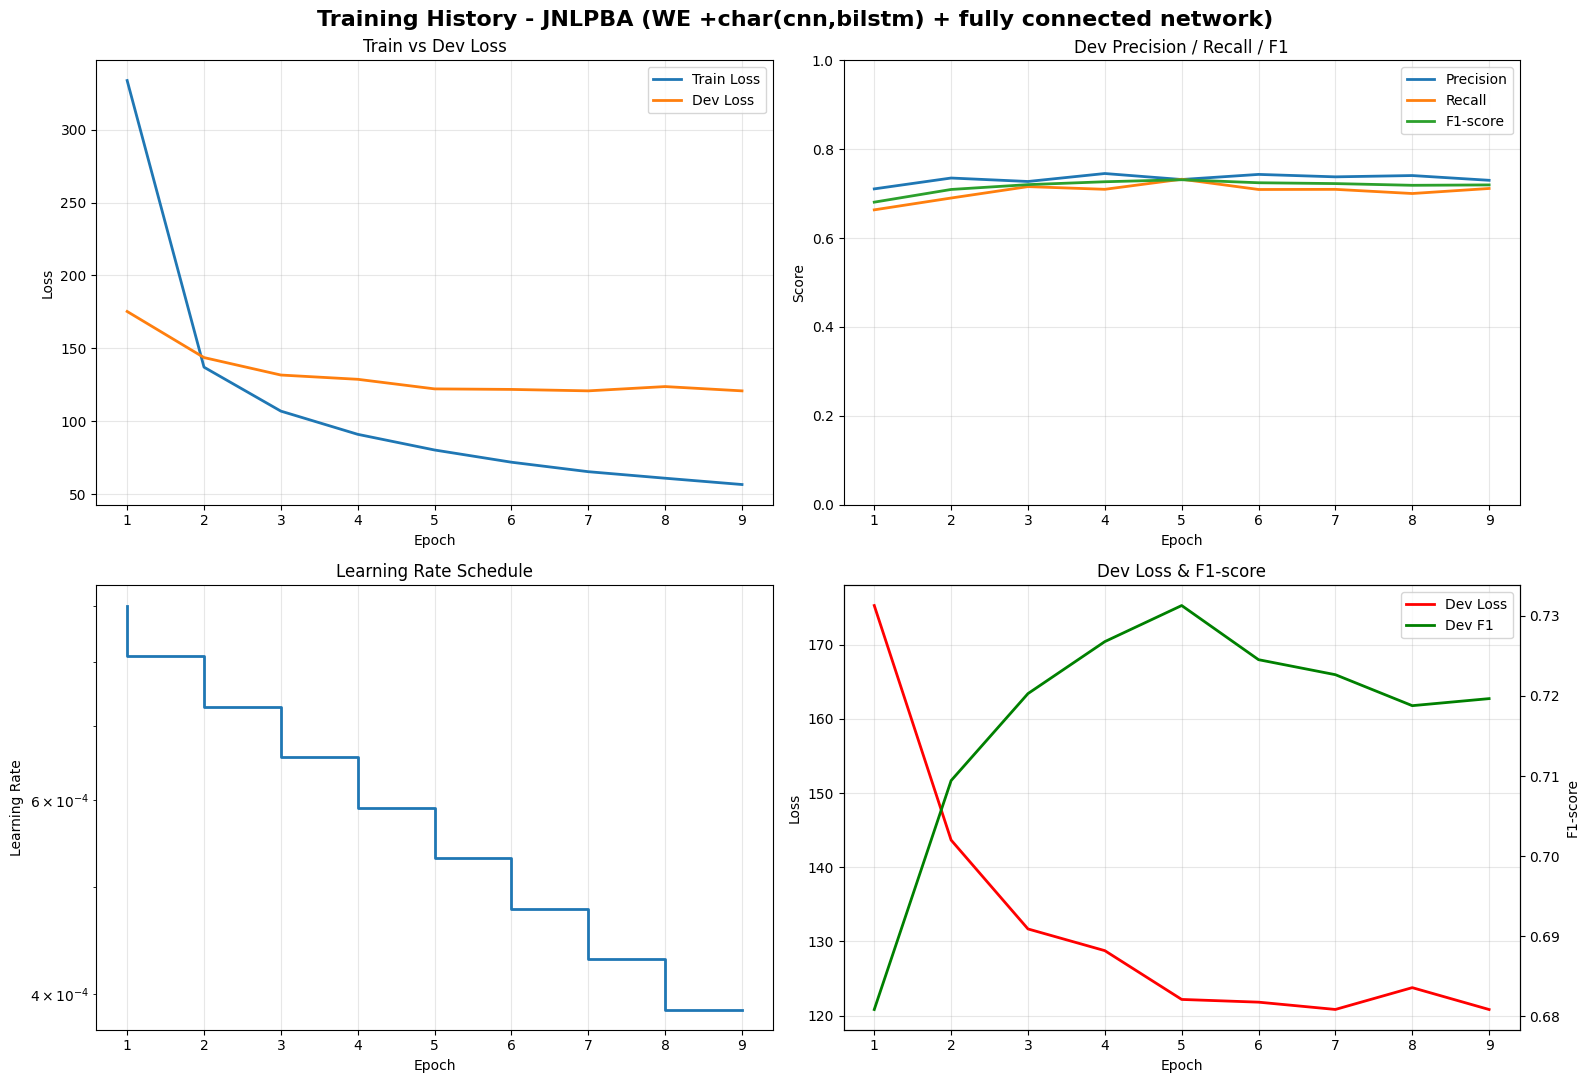


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bilstm) + fully connected network)
Meilleur F1 (dev)       : 0.7313
Meilleure Precision(dev): 0.7453
Meilleur Recall (dev)   : 0.7325
Final train loss        : 56.5918
Final dev loss          : 120.8293
Final learning rate     : 0.000387


In [53]:
plot_training_history(history_we_char_cnn_bilstm_fc, dataset_name="JNLPBA (WE +char(cnn,bilstm) + fully connected network)")

In [55]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_fc/best_model.pt"
model_we_char__bilstm_cnn_fc, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=False,use_fc_fusion=True
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn_fc, targets_we_char__bilstm_cnn_fc = predict_on_test_set(
    model=model_we_char__bilstm_cnn_fc,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn_fc/best_model.pt
Best F1 enregistré: 0.7313
Époque: 4
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O        


Accuracy globale: 0.9241

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 16841
  Unique entity tags in targets: {'I-cell_line', 'I-protein', 'B-RNA', 'I-RNA', 'I-DNA', 'B-cell_line', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Unique entity tags in predictions: {'I-cell_line', 'I-protein', 'I-DNA', 'B-RNA', 'I-RNA', 'B-cell_line', 'O', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


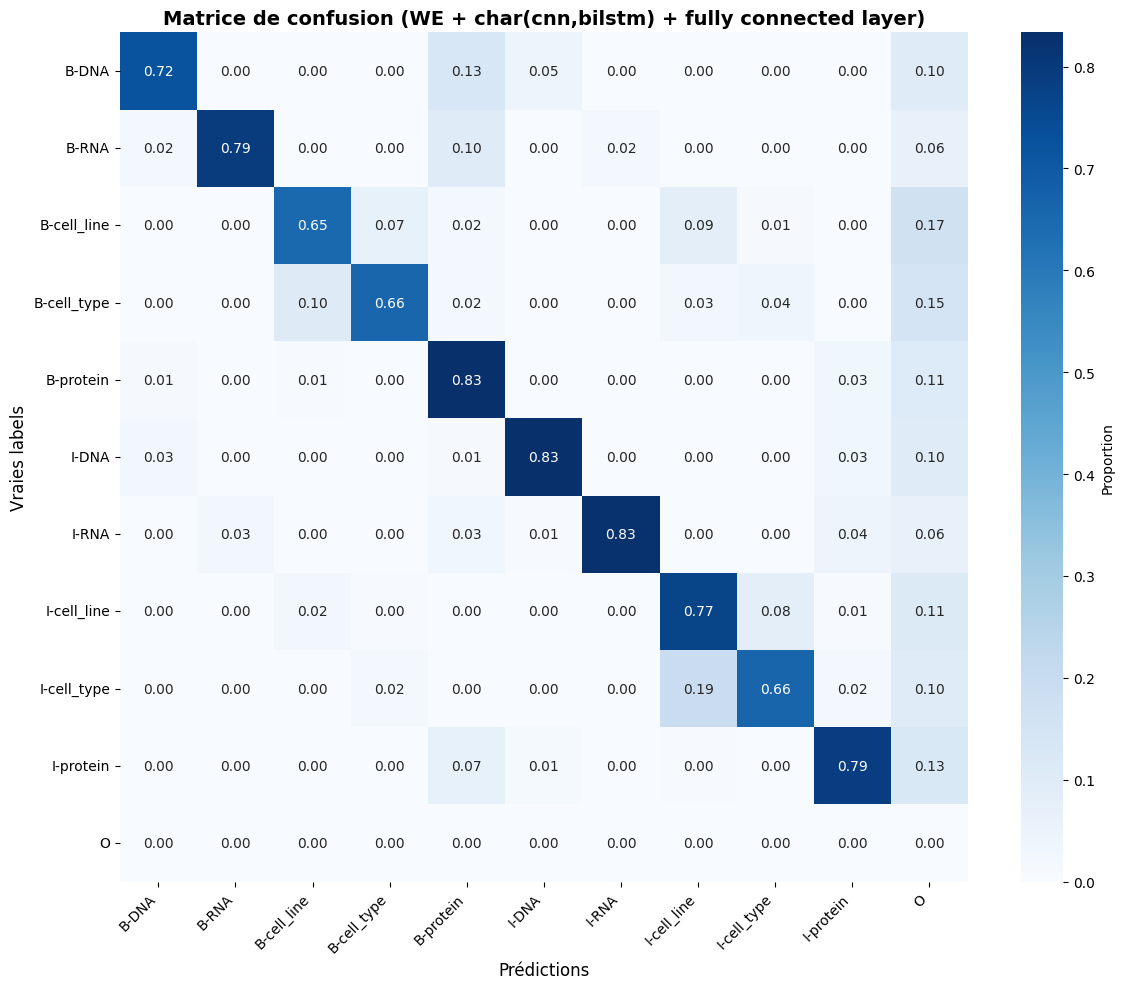

              precision    recall  f1-score   support

       B-DNA       0.86      0.72      0.79       857
       B-RNA       0.85      0.79      0.82        96
 B-cell_line       0.53      0.65      0.58       393
 B-cell_type       0.93      0.66      0.77      1730
   B-protein       0.89      0.83      0.86      4507
       I-DNA       0.92      0.83      0.87      1397
       I-RNA       0.91      0.83      0.87       156
 I-cell_line       0.49      0.77      0.60       792
 I-cell_type       0.93      0.66      0.77      2691
   I-protein       0.93      0.79      0.85      4222
           O       0.00      0.00      0.00         0

    accuracy                           0.76     16841
   macro avg       0.75      0.69      0.71     16841
weighted avg       0.88      0.76      0.81     16841



In [57]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_fc, predictions_we_char__bilstm_cnn_fc)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_fc, targets_we_char__bilstm_cnn_fc) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_fc, targets_we_char__bilstm_cnn_fc) if t != 'O']

if set(predictions_we_char__bilstm_cnn_fc) == set(targets_we_char__bilstm_cnn_fc) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_fc):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_fc,
        targets=targets_we_char__bilstm_cnn_fc,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + fully connected layer)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_fc[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_fc[:10])}")

## Combinaison 10 : WE + char(cnn, bilstm) + fully connected network + attention

In [58]:
model_we_char_cnn_bilstm_fc_attention, history_we_char_cnn_bilstm_fc_attention = run_pipeline(
     dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,030,096


Training: 100%|██████████| 491/491 [17:42<00:00,  2.16s/it]


Epoch 01/40 | Train loss: 345.7892 | Dev loss: 170.8859 | P: 0.6990 R: 0.6780 F1: 0.6843 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6843


Training: 100%|██████████| 491/491 [16:49<00:00,  2.06s/it]


Epoch 02/40 | Train loss: 139.9407 | Dev loss: 142.3494 | P: 0.7273 R: 0.7023 F1: 0.7123 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7123


Training: 100%|██████████| 491/491 [16:50<00:00,  2.06s/it]


Epoch 03/40 | Train loss: 108.4116 | Dev loss: 129.7254 | P: 0.7268 R: 0.7228 F1: 0.7240 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7240


Training: 100%|██████████| 491/491 [16:50<00:00,  2.06s/it]


Epoch 04/40 | Train loss: 91.8078 | Dev loss: 128.3637 | P: 0.7305 R: 0.7113 F1: 0.7180 | LR: 0.000656


Training: 100%|██████████| 491/491 [16:49<00:00,  2.06s/it]


Epoch 05/40 | Train loss: 81.0485 | Dev loss: 123.0660 | P: 0.7255 R: 0.7238 F1: 0.7235 | LR: 0.000590


Training: 100%|██████████| 491/491 [16:49<00:00,  2.06s/it]


Epoch 06/40 | Train loss: 73.0176 | Dev loss: 120.8314 | P: 0.7236 R: 0.7242 F1: 0.7232 | LR: 0.000531


Training: 100%|██████████| 491/491 [16:50<00:00,  2.06s/it]


Epoch 07/40 | Train loss: 66.7722 | Dev loss: 121.3174 | P: 0.7344 R: 0.7079 F1: 0.7189 | LR: 0.000478
Early stopping triggered après 7 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 146.1754
Precision: 0.6406
Recall: 0.6905
F1-score: 0.6610


In [59]:
print_model_layers(model_we_char_cnn_bilstm_fc_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
fusion.0 (Linear)              |       79,400
fusion.1 (Dropout)             |            0
context_lstm (LSTM)            |      337,920
attention_layer.W (Linear)     |          256
emission (Linear)              |        6,156
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,030,096


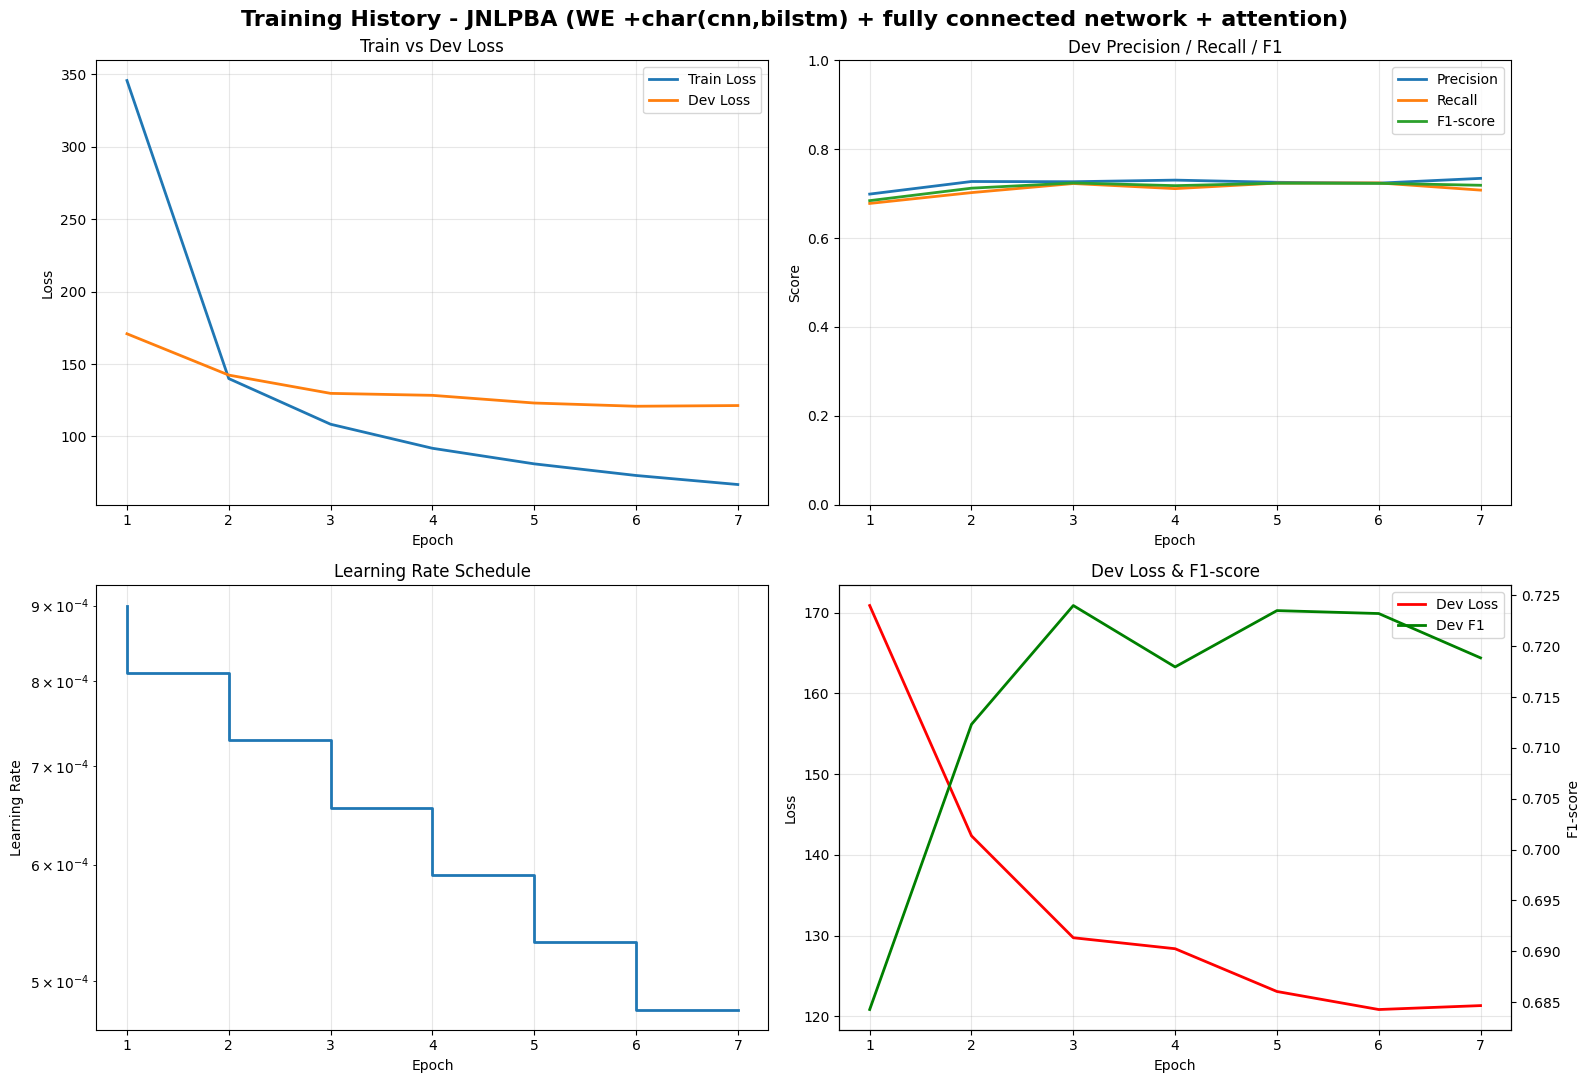


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bilstm) + fully connected network + attention)
Meilleur F1 (dev)       : 0.7240
Meilleure Precision(dev): 0.7344
Meilleur Recall (dev)   : 0.7242
Final train loss        : 66.7722
Final dev loss          : 121.3174
Final learning rate     : 0.000478


In [60]:
plot_training_history(history_we_char_cnn_bilstm_fc_attention, dataset_name="JNLPBA (WE +char(cnn,bilstm) + fully connected network + attention)")

In [61]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt"
model_we_char__bilstm_cnn_attention_fc, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=True
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention_fc,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt
Best F1 enregistré: 0.7240
Époque: 2
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-protein          incorrect
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O


Accuracy globale: 0.9271

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 16841
  Unique entity tags in targets: {'I-cell_line', 'I-protein', 'B-RNA', 'I-RNA', 'I-DNA', 'B-cell_line', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Unique entity tags in predictions: {'I-cell_line', 'I-protein', 'I-RNA', 'I-DNA', 'B-RNA', 'B-cell_line', 'O', 'I-cell_type', 'B-protein', 'B-cell_type', 'B-DNA'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


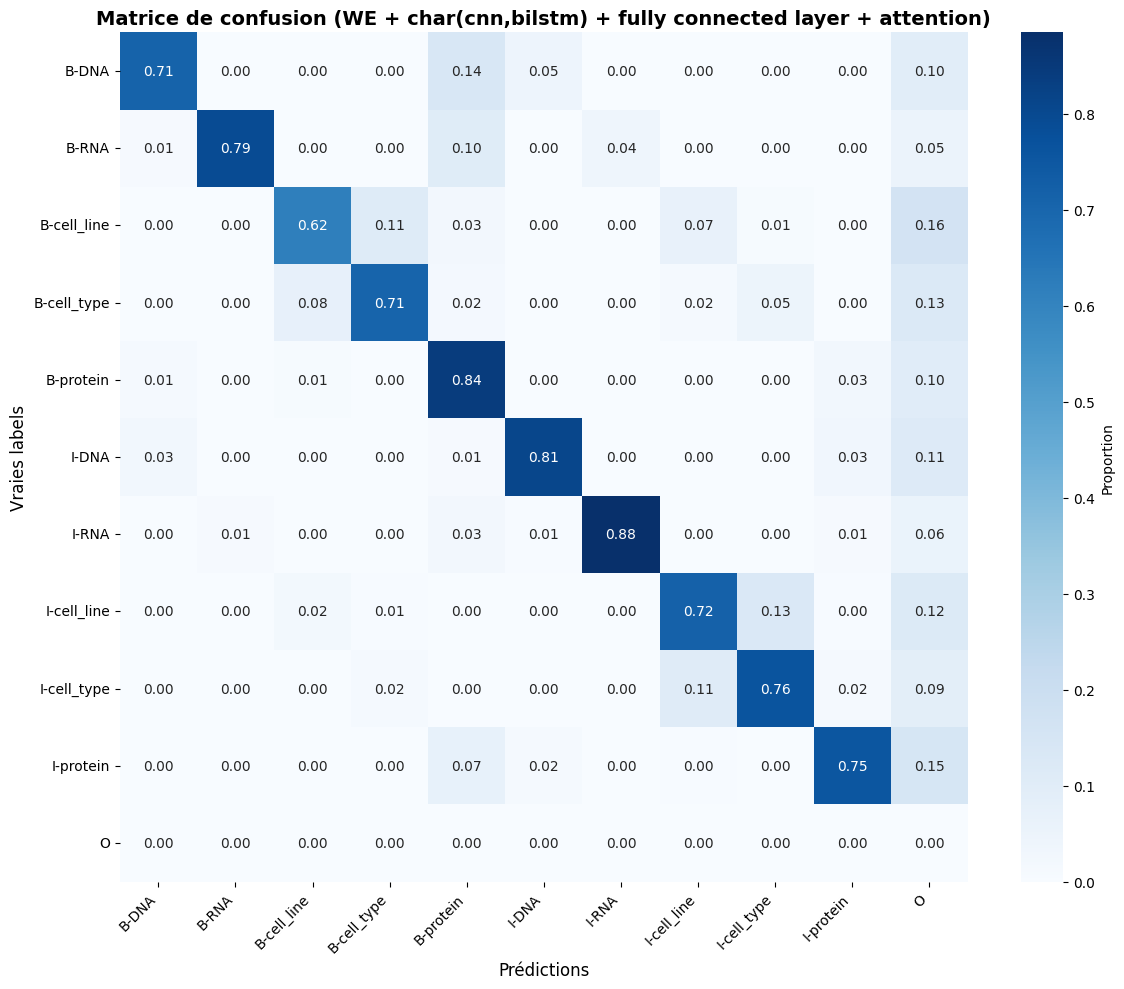

              precision    recall  f1-score   support

       B-DNA       0.84      0.71      0.77       857
       B-RNA       0.86      0.79      0.83        96
 B-cell_line       0.57      0.62      0.59       393
 B-cell_type       0.92      0.71      0.80      1730
   B-protein       0.88      0.84      0.86      4507
       I-DNA       0.91      0.81      0.86      1397
       I-RNA       0.91      0.88      0.90       156
 I-cell_line       0.60      0.72      0.66       792
 I-cell_type       0.91      0.76      0.83      2691
   I-protein       0.93      0.75      0.83      4222
           O       0.00      0.00      0.00         0

    accuracy                           0.77     16841
   macro avg       0.76      0.69      0.72     16841
weighted avg       0.88      0.77      0.82     16841



In [62]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention_fc, predictions_we_char__bilstm_cnn_attention_fc)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc) if t != 'O']

if set(predictions_we_char__bilstm_cnn_attention_fc) == set(targets_we_char__bilstm_cnn_attention_fc) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention_fc):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_attention_fc,
        targets=targets_we_char__bilstm_cnn_attention_fc,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + fully connected layer + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention_fc[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention_fc[:10])}")

#### Comparaison

| #  | Combinaison                               | Accuracy globale (avec O) | Macro Precision | Macro Recall | **Macro F1** | **Weighted F1** |
| -- | ----------------------------------------- | ------------------------- | --------------- | ------------ | ------------ | --------------- |
| 1  | WE                                        | 0.9082                    | 0.74            | 0.54         | **0.62**     | 0.74            |
| 2  | WE + Attention                            | **0.9215**                | 0.75            | 0.67         | **0.70**     | 0.81            |
| 3  | WE + Char-BiLSTM                          | 0.9247                    | 0.76            | 0.69         | **0.72**     | 0.82            |
| 4  | WE + Char-BiLSTM + Attention              | **0.9291**                | 0.76            | 0.69         | **0.72**     | 0.82            |
| 5  | WE + Char-CNN                             | 0.9284                    | 0.76            | 0.68         | **0.71**     | 0.82            |
| 6  | WE + Char-CNN + Attention                 | 0.9268                    | 0.76            | 0.68         | **0.72**     | **0.83**        |
| 7  | WE + Char-(BiLSTM + CNN)                  | 0.9265                    | 0.76            | 0.68         | **0.71**     | 0.81            |
| 8  | WE + Char-(BiLSTM + CNN) + Attention      | **0.9291**                | **0.77**        | 0.68         | **0.72**     | **0.83**        |
| 9  | WE + Char-(BiLSTM + CNN) + FC             | 0.9141                    | 0.75            | **0.69**     | **0.71**     | 0.81            |
| 10 | WE + Char-(BiLSTM + CNN) + FC + Attention | 0.9271                    | 0.76            | 0.69         | **0.72**     | 0.82            |


| Composant ajouté                  | Comparaison directe | Effet observé (tes résultats)                          | Impact mesuré        | Interprétation technique                                                                              |
| --------------------------------- | ------------------- | ------------------------------------------------------ | -------------------- | ----------------------------------------------------------------------------------------------------- |
| **Word Embeddings (WE)**          | —                   | Macro-F1 = **0.62**                                    | Baseline             | Capture uniquement la sémantique lexicale, très sensible aux OOV et aux variantes morphologiques      |
| **Attention (sur WE)**            | (1) → (2)           | Macro-F1 **+0.08** (0.62 → 0.70) <br> Recall **+0.13** | Fort gain            | L’attention compense l’absence de contexte profond en repondérant dynamiquement les tokens pertinents |
| **Char-BiLSTM**                   | (1) → (3)           | Macro-F1 **+0.10**                                     | Très fort            | Capture la morphologie séquentielle (suffixes biomédicaux : *-ase*, *-in*, *-oma*)                    |
| **Char-BiLSTM + Attention**       | (3) → (4)           | F1 ≈ stable                                            | Léger                | L’attention devient redondante car le BiLSTM encode déjà le contexte local                            |
| **Char-CNN**                      | (1) → (5)           | Macro-F1 **+0.09**                                     | Fort                 | Capture des motifs morphologiques locaux (n-grammes de caractères)                                    |
| **Char-CNN + Attention**          | (5) → (6)           | Weighted-F1 **↑ 0.82 → 0.83**                          | Modéré               | L’attention améliore surtout les entités fréquentes (protein, cell_type)                              |
| **Char-BiLSTM + Char-CNN**        | (5)/(3) → (7)       | Gain marginal                                          | Faible               | Redondance partielle entre CNN (local) et BiLSTM (séquentiel)                                         |
| **Char-(BiLSTM+CNN) + Attention** | (7) → (8)           | **Meilleur Weighted-F1 = 0.83**                        | Fort                 | L’attention exploite la complémentarité CNN + BiLSTM                                                  |
| **Fully Connected (FC)**          | (7) → (9)           | Performance ↓                                          | Négatif seul         | Projection linéaire sans pondération contextuelle → perte d’information                               |
| **FC + Attention**                | (9) → (10)          | Performance récupérée                                  | Positif conditionnel | Le FC devient utile uniquement lorsqu’il est guidé par l’attention                                    |

Test on a set of examples

In [63]:
import torch

# =========================
# 1. Chargement checkpoint
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt"
ckpt = torch.load(checkpoint_path, map_location=device)

# =========================
# 2. Récupération EXACTE des objets du training
# =========================
# Ces objets doivent venir des loaders utilisés à l'entraînement
train_loader = results_jnlpba["train_loader"]
vocab        = results_jnlpba["vocab"]
char_vocab   = results_jnlpba["char_vocab"]
tag_to_idx   = results_jnlpba["tag_to_idx"]
idx_to_tag   = results_jnlpba["idx_to_tag"]

# =========================
# 3. Reconstruction du modèle (IDENTIQUE au training)
# =========================
model = CombinatorialNER(
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    pretrained_embeddings=results_jnlpba["pretrained_embeddings"],
    word_embed_dim=200,
    lstm_hidden_dim=256,   # JNLPBA
    dropout=0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

def token_accuracy(all_preds, all_golds):
    correct = 0
    total = 0
    for preds, golds in zip(all_preds, all_golds):
        for p, g in zip(preds, golds):
            if g != "<PAD>":
                total += 1
                if p == g:
                    correct += 1
    return correct / total

def token_accuracy_single(preds, golds):
    correct = 0
    total = 0
    for p, g in zip(preds, golds):
        if g != "<PAD>":
            total += 1
            if p == g:
                correct += 1
    return correct / total if total > 0 else 0.0


# =========================
# 4. Fonction de prédiction CORRECTE
# =========================
def predict_sentence(
    model,
    sentence,
    vocab,
    char_vocab,
    idx_to_tag,
    device,
    max_seq_len=100,
    max_char_len=20
):
    model.eval()

    PAD_WORD = vocab["<PAD>"]
    UNK_WORD = vocab["<UNK>"]
    PAD_CHAR = char_vocab["<PAD>"]
    UNK_CHAR = char_vocab["<UNK>"]

    # 1. Troncature
    tokens = sentence[:max_seq_len]
    seq_len = len(tokens)

    # 2. Word IDs
    word_ids = [vocab.get(w.lower(), UNK_WORD) for w in tokens]
    word_ids += [PAD_WORD] * (max_seq_len - seq_len)

    # 3. Char IDs
    char_seqs = []
    for w in tokens:
        chars = [char_vocab.get(c, UNK_CHAR) for c in w[:max_char_len]]
        chars += [PAD_CHAR] * (max_char_len - len(chars))
        char_seqs.append(chars)

    char_seqs += [[PAD_CHAR] * max_char_len] * (max_seq_len - seq_len)

    # 4. Tensors
    word_tensor = torch.tensor(word_ids).unsqueeze(0).to(device)
    char_tensor = torch.tensor(char_seqs).unsqueeze(0).to(device)

    mask = torch.zeros((1, max_seq_len), dtype=torch.bool).to(device)
    mask[:, :seq_len] = True

    # 5. Inference CRF
    with torch.no_grad():
        predictions = model(word_tensor, char_tensor, mask)
        predicted_ids = predictions[0][:seq_len]

    return [idx_to_tag[i] for i in predicted_ids]



# =========================
# 5. Tes phrases de test
# =========================
test_data = [
    # Protein + Cell line
    (
        ["Octamer-binding", "proteins", "from", "HeLa", "cells", "stimulate", "transcription"],
        ["B-protein", "I-protein", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA example
    (
        ["The", "BRCA1", "gene", "is", "associated", "with", "breast", "cancer"],
        ["O", "B-DNA", "O", "O", "O", "O", "B-cell_type", "O"]
    ),
    # RNA example
    (
        ["mRNA", "expression", "in", "Jurkat", "cells", "was", "upregulated"],
        ["B-RNA", "O", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # Cell type example
    (
        ["T", "lymphocytes", "play", "a", "key", "role", "in", "immune", "response"],
        ["B-cell_type", "I-cell_type", "O", "O", "O", "O", "O", "O", "O"]
    ),
    # Overlapping adjacent entities
    (
        ["p53", "and", "BRCA1", "regulate", "DNA", "replication"],
        ["B-protein", "O", "B-DNA", "O", "B-DNA", "O"]
    ),
    # Mixed entities
    (
        ["The", "RNA", "of", "Jurkat", "T", "cells", "is", "similar", "to", "HeLa", "cells"],
        ["O", "B-RNA", "O", "B-cell_line", "B-cell_type", "I-cell_line", "O", "O", "O", "B-cell_line", "I-cell_line"]
    ),
    # Long sentence with multiple types
    (
        ["p53", "protein", "binds", "to", "BRCA1", "DNA", "in", "HeLa", "and", "Jurkat", "cells", "during", "transcription"],
        ["B-protein", "I-protein", "O", "O", "B-DNA", "I-DNA", "O", "B-cell_line", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA + RNA + protein in one sentence
    (
        ["BRCA1", "gene", "transcribes", "mRNA", "which", "produces", "p53", "protein"],
        ["B-DNA", "O", "O", "B-RNA", "O", "O", "B-protein", "I-protein"]
    ),
]

# =========================
# 6. Évaluation lisible
# =========================
all_preds = []
all_golds = []

for i, (sentence, gold) in enumerate(test_data, 1):
    preds = predict_sentence(model, sentence, vocab, char_vocab, idx_to_tag, device)

    all_preds.append(preds)
    all_golds.append(gold)

    # Accuracy par phrase
    acc_sentence = token_accuracy_single(preds, gold)

    print(f"Example {i}")
    print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s}")
    print("-" * 50)
    for t, g, p in zip(sentence, gold, preds):
        print(f"{t:15s} {g:15s} {p:15s}")

    print(f"\nToken accuracy (sentence): {acc_sentence:.4f}")
    print("=" * 60 + "\n")

# Accuracy globale
acc_global = token_accuracy(all_preds, all_golds)
print(f"Global token accuracy: {acc_global:.4f}")

Example 1
Token           Gold            Predicted      
--------------------------------------------------
Octamer-binding B-protein       B-protein      
proteins        I-protein       I-protein      
from            O               O              
HeLa            B-cell_line     B-cell_line    
cells           I-cell_line     I-cell_line    
stimulate       O               O              
transcription   O               O              

Token accuracy (sentence): 1.0000

Example 2
Token           Gold            Predicted      
--------------------------------------------------
The             O               O              
BRCA1           B-DNA           B-DNA          
gene            O               I-DNA          
is              O               O              
associated      O               O              
with            O               O              
breast          B-cell_type     O              
cancer          O               O              

Token accuracy (sentence)